# Toy Distributions for L2HMC

## Setup

### Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# Global imports
import sys
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import horovod.tensorflow as hvd
hvd.init()

from collections import namedtuple

# append parent directory to `sys.path`
# to load from modules in `../l2hmc-qcd/`
module_path = os.path.join('..')
if module_path not in sys.path:
    sys.path.append(module_path)

# Local imports
from utils.attr_dict import AttrDict
from utils.training_utils import setup_directories, train_dynamics
from dynamics.base_dynamics import BaseDynamics
from dynamics.generic_dynamics import GenericDynamics
from network.generic_network import GenericNetwork
from config import (State, NetWeights, MonteCarloStates,
                    DynamicsConfig, NetworkConfig, LearningRateConfig,
                    BASE_DIR, BIN_DIR, TF_FLOAT)

from utils.distributions import (plot_samples2D, contour_potential,
                                 two_moons_potential, sin_potential,
                                 sin_potential1, sin_potential2)

sns.set_palette('bright')

2020-09-10 23:28:36,091:INFO:Number of devices: 1


In [2]:
sns.set(style="ticks", context="notebook")
plt.style.use("dark_background")

## Helper functions

In [3]:
from config import LearningRateConfig, DynamicsConfig, NetworkConfig

def identity(x):
    return x

def get_dynamics(flags):
    """Return `GenericDynamics` object, initialized from `flags`."""
    config = DynamicsConfig(eps=flags.eps,
                            num_steps=flags.num_steps,
                            hmc=flags.hmc,
                            eps_fixed=flags.eps_fixed,
                            model_type=flags.model_type)


    net_config = NetworkConfig(units=flags.units,
                               dropout_prob=flags.dropout_prob,
                               name=flags.network_name,
                               activation_fn=flags.activation_fn)

    lr_config = LearningRateConfig(flags.lr_init,
                                   decay_steps=flags.decay_steps,
                                   decay_rate=flags.decay_rate,
                                   warmup_steps=flags.warmup_steps)

    dynamics = GenericDynamics(params=flags,
                               config=config,
                               lr_config=lr_config,
                               normalizer=identity,
                               network_config=net_config,
                               potential_fn=POTENTIAL_FN,
                               name=MODEL_TYPE)
    
    return dynamics

In [4]:
import utils.file_io as io
from utils.distributions import contour_potential

%matplotlib inline

def plot_chains(dirs, x_arr, potential_fn, label=None, cmap='rainbow'):
    figs_dir = os.path.join(dirs.log_dir, 'figures')
    io.check_else_make_dir(figs_dir)

    x_arr = tf.convert_to_tensor(x_arr).numpy()

    for chain in range(4):
        fig, ax = plt.subplots()
        xy = np.array((x_arr[1000:, chain, 0], x_arr[1000:, chain, 1]))
        #sns.kdeplot(*xy, ax=ax)
        #grid = xy.reshape(2, -1).T
        #Z = np.exp(-POTENTIAL_FN(grid))
        #_ = ax.contourf(xy[0], xy[1], Z.reshape(xy[0].shape, xy[1].shape), cmap='inferno')
        #xlim = np.abs(np.floor(np.min(xy[0]))) + 1
        #ylim = np.abs(np.floor(np.max(xy[1]))) + 1
        xlim = 5
        ylim = 5
        _ = contour_potential(POTENTIAL_FN, ax=ax, cmap='rainbow', xlim=xlim, ylim=ylim)
        _ = ax.plot(*xy, alpha=0.3, mew=0.9, ls='', marker='+',
                    color='white', label='l2hmc samples')
        #_ = ax.legend(markerscale=5., loc='best')
        _ = ax.set_xlim((-xlim, xlim))
        _ = ax.set_ylim((-ylim, ylim))
        out_file = os.path.join(figs_dir, f'trained_samples_chain{chain}.png')
        print(f'Saving figure to: {out_file}')
        _ = plt.savefig(out_file, dpi=400, bbox_inches='tight')
        plt.show()

In [5]:
def plot_density_estimation(potential_fn, x_l2hmc, x_hmc,
                            title=None, cmap=None, num_plots=5):
    def _format_arr(x):
        x = np.array(x)
        n = x.shape[0]
        therm = 2 * n // 10  # Drop first 20% of samples (thermalization)
        return x[therm:]
    
    x_l2hmc = _format_arr(x_l2hmc)
    x_hmc = _format_arr(x_hmc)
    
    for idx in range(num_plots):
        fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
        _ = contour_potential(potential_fn, title=title, ax=axes[0], cmap=cmap)
        _ = sns.kdeplot(x_l2hmc[:, idx, 0], x_l2hmc[:, idx, 1],
                        shade=True, cmap=cmap, ax=axes[1])
        _ = sns.kdeplot(x_hmc[:, idx, 0], x_hmc[:, idx, 1],
                        shade=True, cmap=cmap, ax=axes[2])
        _ = axes[1].set_title('L2HMC samples')
        _ = axes[2].set_title('HMC samples')
        plt.tight_layout()
        
    return fig, axes

### Plot examples of (toy) target distributions:

In [6]:
%matplotlib inline

In [7]:
plt.colormaps()

['Accent',
 'Accent_r',
 'Blues',
 'Blues_r',
 'BrBG',
 'BrBG_r',
 'BuGn',
 'BuGn_r',
 'BuPu',
 'BuPu_r',
 'CMRmap',
 'CMRmap_r',
 'Dark2',
 'Dark2_r',
 'GnBu',
 'GnBu_r',
 'Greens',
 'Greens_r',
 'Greys',
 'Greys_r',
 'OrRd',
 'OrRd_r',
 'Oranges',
 'Oranges_r',
 'PRGn',
 'PRGn_r',
 'Paired',
 'Paired_r',
 'Pastel1',
 'Pastel1_r',
 'Pastel2',
 'Pastel2_r',
 'PiYG',
 'PiYG_r',
 'PuBu',
 'PuBuGn',
 'PuBuGn_r',
 'PuBu_r',
 'PuOr',
 'PuOr_r',
 'PuRd',
 'PuRd_r',
 'Purples',
 'Purples_r',
 'RdBu',
 'RdBu_r',
 'RdGy',
 'RdGy_r',
 'RdPu',
 'RdPu_r',
 'RdYlBu',
 'RdYlBu_r',
 'RdYlGn',
 'RdYlGn_r',
 'Reds',
 'Reds_r',
 'Set1',
 'Set1_r',
 'Set2',
 'Set2_r',
 'Set3',
 'Set3_r',
 'Spectral',
 'Spectral_r',
 'Wistia',
 'Wistia_r',
 'YlGn',
 'YlGnBu',
 'YlGnBu_r',
 'YlGn_r',
 'YlOrBr',
 'YlOrBr_r',
 'YlOrRd',
 'YlOrRd_r',
 'afmhot',
 'afmhot_r',
 'autumn',
 'autumn_r',
 'binary',
 'binary_r',
 'bone',
 'bone_r',
 'brg',
 'brg_r',
 'bwr',
 'bwr_r',
 'cet_gray',
 'cet_gray_r',
 'cividis',
 'cividis_

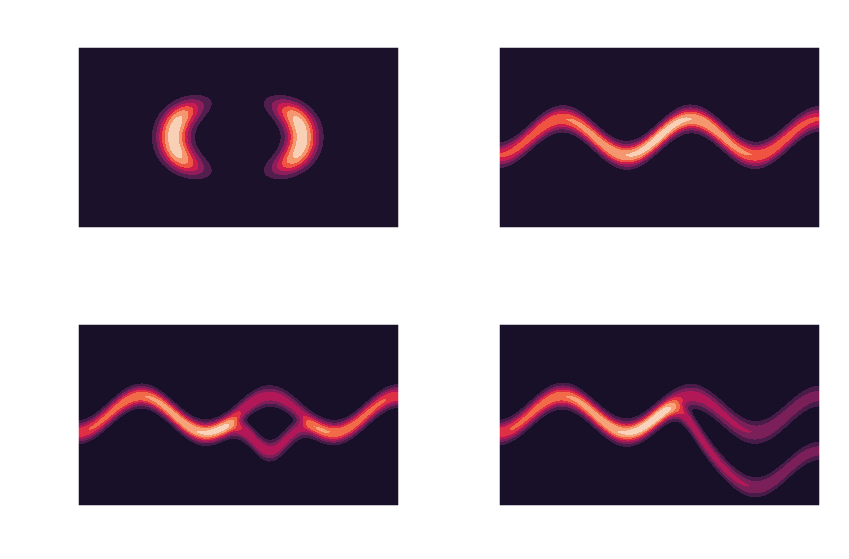

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2)
axes = axes.flatten()
names = ['two_moons', 'sin', 'sin_hard', 'sin_harder']
potentials = [two_moons_potential, sin_potential, sin_potential1, sin_potential2]
potentials_and_axes = zip(potentials, axes)
potentials_dict = {}
for idx, (p_fn, ax) in enumerate(zip(potentials, axes)):
    _ = contour_potential(p_fn, ax, title=f'{names[idx]}', cmap='rocket')
    potentials_dict[names[idx]] = p_fn
plt.show()

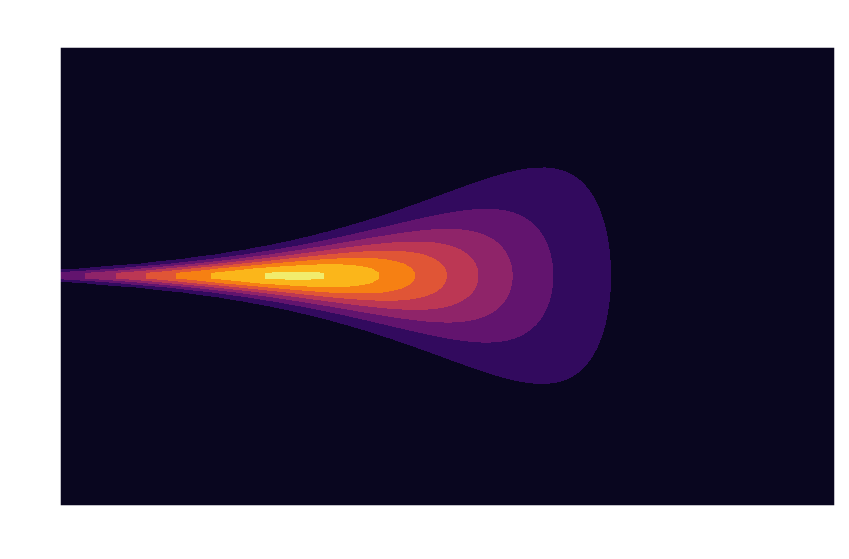

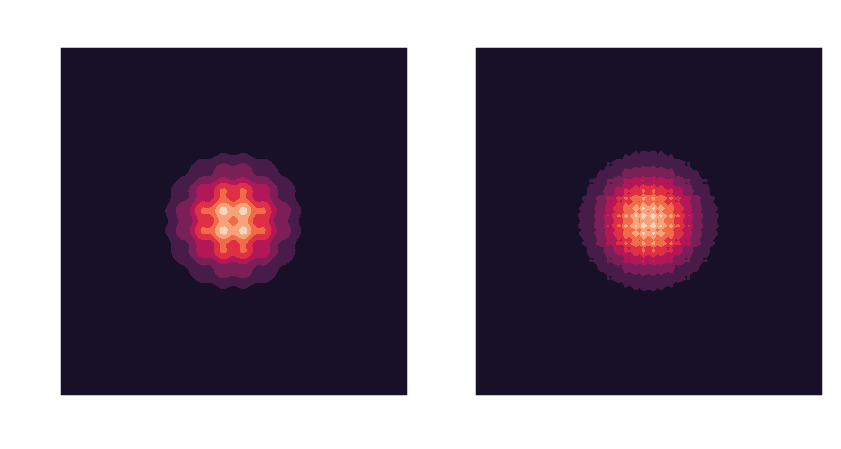

In [9]:
from utils.distributions import GaussianFunnel, RoughWell

funnel = GaussianFunnel()
funnel_potential = funnel.get_energy_function()
fig, ax = plt.subplots()
_ = contour_potential(funnel_potential, ax=ax, title=f'Gaussian Funnel Potential')
plt.show()

rough_well = RoughWell(dim=2, eps=0.1, easy=True)
rough_well_hard = RoughWell(dim=2, eps=0.1, easy=False)

rw_potential = rough_well.get_energy_function()
rwh_potential = rough_well_hard.get_energy_function()

fig, axes = plt.subplots(nrows=1, ncols=2)
axes = axes.flatten()
ax0 = contour_potential(rw_potential, ax=axes[0], cmap='rocket', title='Rough Well Potential')
ax1 = contour_potential(rwh_potential, ax=axes[1], cmap='rocket', title='Rough Well Potential (Hard)')
ax0.set_aspect('equal')
ax1.set_aspect('equal')

potentials_dict.update({
    'funnel': funnel_potential,
    'rough_well': rw_potential,
    'rough_well_hard': rwh_potential,
})

In [22]:
from utils.distributions import GaussianMixtureModel, meshgrid
import tensorflow_probability as tfp
tfd = tfp.distributions
floatx = tf.keras.backend.floatx()


def make_gmm_model(mus, sigmas, pis):
    def to_tensors(x):
        return (tf.convert_to_tensor(i, dtype=floatx) for i in x)
    
    mus, sigmas, pis = to_tensors([mus, sigmas, pis])
    gmm = tfd.Mixture(
        cat=tfd.Categorical(probs=pis),
        components=[
            tfd.MultivariateNormalDiag(loc=m, scale_diag=s)
            for m, s in zip(mus, sigmas)
        ]
    )
    
    def potential(x):
        return -1. * gmm.log_prob(x)
    
    #model = GaussianMixtureModel(mus, sigmas, pis) 
    #potential_fn = lambda x: -1. * model.dist.log_prob(x)
    #return model, potential_fn
    
    return gmm, potential

Gaussian mixture models:

 1. 2-Component mixture: 
 $$x \sim p(x) \equiv \frac{1}{2}\mathcal{N}(\vec{x}_{0}, \Sigma_{0}) + \frac{1}{2}\mathcal{N}(\vec{x}_{1}, \Sigma_{1})$$
 2. $4\times 4$ Lattice of Gaussians: 
 $$x\sim\mathcal{N}(\vec{x}_{ij}, \Sigma_{ij})$$

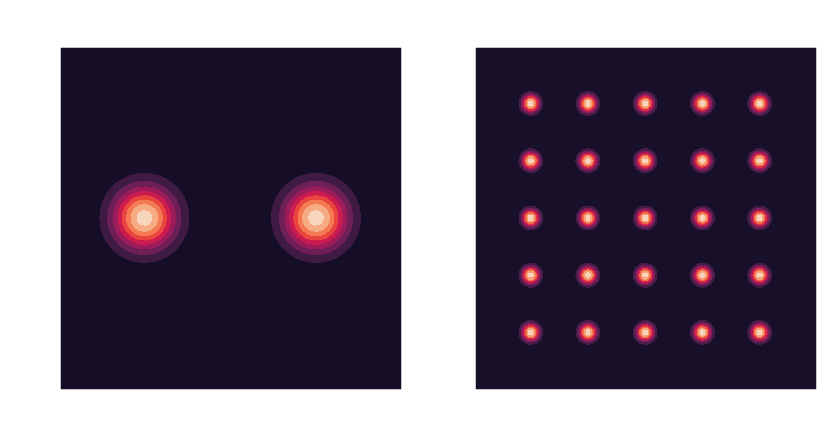

In [25]:
# ==== Mixture of two components
mus = [(-1., 0), (1., 0)]
sigmas = [0.25 * np.ones(2) for _ in range(len(mus))]
pis = len(mus) * [1. / len(mus)]

gmm, gmm_potential = make_gmm_model(mus, sigmas, pis)


# ==== 4x4 Lattice of Gaussians
# xy locations of each component
mus = [(-2, -2), (-2, -1), (-2, +0), (-2, +1), (-2, +2),
       (-1, -2), (-1, -1), (-1, +0), (-1, +1), (-1, +2),
       (+0, -2), (+0, -1), (+0, +0), (+0, +1), (+0, +2),
       (+1, -2), (+1, -1), (+1, +0), (+1, +1), (+1, +2),
       (+2, -2), (+2, -1), (+2, +0), (+2, +1), (+2, +2)]

sigmas = [0.1 * np.ones(2) for _ in range(len(mus))]
pis = len(mus) * [1. / len(mus)]

gmm_latt, gmm_latt_potential = make_gmm_model(mus, sigmas, pis)


potentials_dict.update({
    'gmm': gmm_potential,
    'lattice_of_gaussians': gmm_latt_potential,
})


# ==== Plot contours of both potentials
fig, axes = plt.subplots(ncols=2)
axes = axes.flatten()

ax0 = contour_potential(gmm_potential, ax=axes[0],
                        cmap='rocket', xlim=2, ylim=2,
                        title='Gaussian Mixture Model')

ax1 = contour_potential(glattice_potential, ax=axes[1],
                        cmap='rocket', xlim=3, ylim=3,
                        title='Lattice of Gaussians')
    
_ = [ax.set_aspect('equal') for ax in axes]

## Define parameters of the model and target distribution

In [36]:
import utils.file_io as io
import datetime

LOGS_DIR = os.path.abspath('../../logs')

# DEFINE THE TARGET DISTRIBUTION
MODEL_TYPE = 'gmm'
POTENTIAL_FN = potentials_dict[MODEL_TYPE]

now = datetime.datetime.now()
date_str = now.strftime('%Y-%m-%d')
timestamp = now.strftime('%Y-%m-%d-%H%M%S')

log_dir = os.path.join(LOGS_DIR, f'{MODEL_TYPE}', date_str)
if os.path.isdir(log_dir):
    log_dir = os.path.join(log_dir, timestamp)
    
io.check_else_make_dir(log_dir)


flags = AttrDict({
    'restore': False,
    'horovod': False,
    'profiler': False,
    'xdim': 2,
    'eps': 0.1,
    'batch_size': 512,
    'num_steps': 10,
    'beta_init': 0.05,
    'beta_final': 1.,
    'aux_weight': 0.0,
    'compile': True,
    'hmc_steps': 0,
    'lr_init': 1e-3,
    'train_steps': 10000,
    'clip_val': 0.0,
    'decay_rate': 0.96,
    'save_steps': 1000,
    'logging_steps': 10,
    'warmup_steps': 0,
    'print_steps': 10,
    'units': [256, 256],
    'hmc': False,
    'eps_fixed': False,
    'model_type': MODEL_TYPE,
    'network_name': 'GenericNetwork',
    'dropout_prob': 0.,
    'activation_fn': tf.nn.relu,
    'log_dir': log_dir,
})

flags.decay_steps = flags.train_steps // 5
#flags.warmup_steps = flags.train_steps // 10

2020-09-11 03:21:18,148:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-11/2020-09-11-032118


## Train

### Start by training HMC to find optimal step-size $\varepsilon$ and thermalized config $x_{\mathrm{therm}}$ 

In [16]:
flags.hmc_steps = 10000

x_shape = (flags.batch_size, flags.xdim)
x = tf.random.normal(shape=x_shape, dtype=TF_FLOAT)

net_config = NetworkConfig(units=flags.units,
                           dropout_prob=flags.dropout_prob,
                           name=flags.network_name,
                           activation_fn=flags.activation_fn)

lr_config = LearningRateConfig(flags.lr_init,
                     decay_steps=flags.decay_steps,
                     decay_rate=flags.decay_rate,
                     warmup_steps=flags.warmup_steps)

# TRAIN HMC
if flags.hmc_steps > 0:
hmc_flags = AttrDict(dict(flags))
    #hmc_flags.train_steps = hmc_flags.pop('hmc_steps')
    hmc_flags.train_steps = 10000
    hmc_flags.logging_steps = hmc_flags.train_steps // 20
    hmc_flags.beta_final = hmc_flags.beta_init
    hmc_flags.compile = True
    hmc_config = DynamicsConfig(eps=hmc_flags.eps,
                                num_steps=hmc_flags.num_steps,
                                hmc=True,
                                eps_trainable=flags.eps_trainable,
                                model_type=MODEL_TYPE)
    hmc_dynamics = GenericDynamics(params=hmc_flags,
                                   config=hmc_config,
                                   lr_config=lr_config,
                                   network_config=net_config,
                                   potential_fn=POTENTIAL_FN,
                                   name=MODEL_TYPE)
    hmc_dirs = setup_directories(hmc_flags, 'training_hmc')
    x, train_data = train_dynamics(hmc_dynamics, hmc_flags, dirs=hmc_dirs, x=x)
    
    output_dir = os.path.join(hmc_dirs.train_dir, 'outputs')
    train_data.save_data(output_dir)
    flags.eps = hmc_dynamics.eps.numpy()

AttributeError: 'AttrDict' object has no attribute 'decay_steps'

In [7]:
flags.eps = hmc_dynamics.eps.numpy()

### Create `GenericDynamics` object

In [27]:
dynamics = get_dynamics(flags)

In [37]:
#dynamics.lr_config.lr_init = 1e-3
#dynamics.lr_config.warmup_steps = 0
#flags.clip_val = 0. 
#flags.aux_weight = 0.
#flags.beta_init = 0.1
net_config = dynamics.net_config
net_config.update({
    'units': [256, 256],
})

dynamics.__init__(params=flags,
                  config=dynamics.config,
                  lr_config=dynamics.lr_config,
                  network_config=net_config,
                  potential_fn=dynamics.potential_fn)

In [38]:
flags.beta_init

0.05

In [40]:
dynamics.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

### Train L2HMC sampler using HMC sampler as starting point

In [41]:
dirs = setup_directories(flags)
x = tf.random.normal(dynamics.x_shape)
x, train_data = train_dynamics(dynamics, flags, dirs=dirs, x=x)

2020-09-11 03:23:39,732:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-11/2020-09-11-032118/training
2020-09-11 03:23:39,732:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-11/2020-09-11-032118/training/train_data
2020-09-11 03:23:39,733:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-11/2020-09-11-032118/training/checkpoints
2020-09-11 03:23:39,734:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-11/2020-09-11-032118/training/summaries
2020-09-11 03:23:39,735:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-11/2020-09-11-032118/training/dynamics_configs
2020-09-11 03:23:39,736:INFO:Saving FLAGS to /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-11/2020-09-11-032118/training/FLAGS.z.
2020-09-11 03:23:40,915:INFO:************************************************************************************************************************
2020-09-11 03:24:00,084:INFO:Compiled `dynamics.train_step` usi

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
     0/10000    0.1022      2.605       0.9074      0.1017       0.05     -0.004003  
    10/10000   0.09796      5.518       0.6149      0.106      0.05015     0.002351  
    20/10000   0.09763      2.155       0.6729      0.1072      0.0503     -0.00362  
    30/10000   0.09757      0.3057      0.7304      0.1085     0.05045     0.002511  
    40/10000    0.1095     -0.2892      0.6942      0.1121      0.0506    0.0008554  
    50/10000    0.1129      0.5135      0.7055      0.1144     0.05075     -0.01415  
    60/10000    0.1125      0.474       0.7523      0.1177     0.05091     0.006854  
    70/10000    0.1002      -1.196      0.7096       0.12      0.05106     0.004087  
    80/10000     0.11       -1.239      0.6523      0.120

   900/10000    0.1246      1.472       0.6511      0.1081     0.06547      0.0072   
   910/10000    0.123      -0.2994      0.5472      0.1106     0.06567     0.005989  
   920/10000    0.1124      -1.492      0.5358      0.1112     0.06587    -0.001249  
   930/10000    0.1256      -2.924      0.6183      0.1103     0.06606     0.001845  
   940/10000    0.118       -4.288      0.6594      0.1098     0.06626     -0.01546  
   950/10000    0.1092      -5.065      0.6863      0.1098     0.06646     0.008555  
   960/10000    0.1422      -5.531      0.6861      0.1096     0.06666    -0.002293  
   970/10000    0.1313      -4.451      0.6468      0.1094     0.06686    -0.0006861 
   980/10000    0.1255      -5.604      0.6483      0.1096     0.06706     0.001769  
   990/10000    0.1285      -5.816      0.6881      0.1098     0.06726    -0.0002273 
Saving configs from rank 0 to: /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-11/2020-09-11-032118/training/train_data/x_rank0.z.
--------------

  1780/10000    0.1361      -4.235      0.6909      0.1064     0.08522     0.001935  
  1790/10000    0.1366      -1.455      0.5637      0.1031     0.08548    -0.003416  
  1800/10000    0.1464      -3.746      0.6515      0.1007     0.08573     0.00693   
  1810/10000    0.1507      -3.913      0.6962     0.09867     0.08599     0.004648  
  1820/10000    0.1541      -4.733      0.7104     0.09815     0.08625    -0.0004507 
  1830/10000    0.1336      -4.772      0.7251     0.09696     0.08651    -0.004721  
  1840/10000    0.1312      -2.457      0.6635     0.09371     0.08677    -0.0006782 
  1850/10000    0.1416      -3.16       0.7087     0.09264     0.08703    -0.003555  
  1860/10000    0.1293      -2.869      0.7128     0.09238     0.08729     -0.00209  
  1870/10000    0.1355      -4.119      0.6918     0.09333     0.08755    0.0009805  
  1880/10000    0.1248      -4.46       0.7156     0.09506     0.08781     0.007283  
  1890/10000    0.1375      -3.625      0.6446     0.0

  2660/10000    0.1521      -1.525      0.6387      0.1088      0.1109    -0.0008016 
  2670/10000    0.1751      -3.526      0.7101      0.108       0.1113    -0.001513  
  2680/10000    0.1969      -2.276      0.7108      0.108       0.1116    0.0004571  
  2690/10000    0.1694      -3.578      0.6975      0.1087      0.1119    -1.739e-05 
  2700/10000    0.1916      -3.983      0.7483      0.1086      0.1123    -0.001243  
  2710/10000    0.1581      -3.06       0.6557      0.1081      0.1126     0.004098  
  2720/10000    0.1757      16.28       0.453       0.1019      0.1129    -0.001276  
  2730/10000    0.1979      2.088       0.5419      0.1099      0.1133     0.001548  
  2740/10000    0.1804      9.172       0.5031      0.1149      0.1136     0.001999  
  2750/10000    0.1982      7.213       0.5757      0.1148      0.114     0.0005954  
  2760/10000    0.213       4.484       0.4564      0.1149      0.1143     0.000241  
  2770/10000    0.192       7.486       0.6368      0.

  3540/10000     0.17       -3.035      0.575      0.07854      0.1444    -0.005118  
  3550/10000    0.1617      -2.79       0.5864     0.07867      0.1448     0.004826  
  3560/10000    0.1878      -2.911      0.6121     0.07627      0.1452    -0.0001295 
  3570/10000    0.1684      -2.144      0.6154     0.07302      0.1457    -0.004236  
  3580/10000    0.1713      -2.609      0.6489      0.0721      0.1461    -0.0004886 
  3590/10000    0.1984      -1.842      0.6613     0.07188      0.1466     0.004272  
  3600/10000    0.1748      -2.116      0.653      0.07196      0.147     -0.0006165 
  3610/10000    0.1731     -0.5058      0.6188     0.07209      0.1474    -0.002864  
  3620/10000    0.1941      3.289       0.5413     0.07204      0.1479     0.004221  
  3630/10000    0.1449      5.192       0.4955     0.07172      0.1483    -0.0002418 
  3640/10000    0.1719      2.212       0.4795     0.07128      0.1488    0.0005922  
  3650/10000    0.1952      0.2539      0.5586     0.0

  4450/10000    0.1376      -2.148      0.6812      0.0597      0.1896     -0.00181  
  4460/10000    0.1423      -2.456      0.7262     0.05949      0.1902    -0.001961  
  4470/10000    0.1329      -2.382      0.7176     0.05933      0.1908    -0.0006762 
  4480/10000    0.1311      -2.068      0.6968     0.05943      0.1913     -0.00115  
  4490/10000    0.1523      -3.441      0.7185     0.05966      0.1919    -0.0001717 
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  4500/10000    0.1322      -1.841      0.6427     0.05975      0.1925     0.001828  
  4510/10000    0.1387      -1.41       0.584      0.05996      0.1931    -0.001305  
  4520/10000    0.1553      -1.599      0.6198     0.06151      0.1936    -0.001325  
  4530/10000    0.122       -1.249      0.6433     0.0612

  5330/10000    0.132      -0.1376      0.5951     0.05511      0.2468    -0.001346  
  5340/10000    0.139       1.433       0.6411     0.05493      0.2476    -0.004898  
  5350/10000    0.138       -1.713      0.6527     0.05498      0.2483    0.0002606  
  5360/10000    0.1385     -0.8423      0.6375     0.05491      0.2491    0.0008222  
  5370/10000    0.1737      -2.566      0.6776     0.05511      0.2498    -0.001331  
  5380/10000    0.1346      -2.449      0.696      0.05542      0.2505    -0.005799  
  5390/10000    0.1643      -2.478      0.6936     0.05609      0.2513    -0.001219  
  5400/10000    0.1448     0.05963      0.7264     0.05655      0.2521     0.000923  
  5410/10000    0.133       -2.273      0.7092     0.05703      0.2528    -0.002628  
  5420/10000    0.1526     -0.7112      0.7148     0.05738      0.2536    -0.0001534 
  5430/10000    0.1419      -2.883      0.7331     0.05739      0.2543    -0.003524  
  5440/10000    0.1551      -2.912      0.708      0.0

  6210/10000    0.1343      -2.714      0.6654     0.05391      0.3213    -0.005263  
  6220/10000    0.1604      -2.815      0.6806     0.05403      0.3222     0.001531  
  6230/10000    0.1558      -3.416      0.7307     0.05427      0.3232    -0.001564  
  6240/10000    0.1491      -3.384      0.7359     0.05428      0.3242    -0.002742  
  6250/10000    0.139       -3.508      0.7616     0.05425      0.3251     0.005111  
  6260/10000    0.1431      -3.244      0.7851     0.05419      0.3261    0.0005791  
  6270/10000    0.1408      -3.27       0.7798     0.05416      0.3271     0.002063  
  6280/10000    0.138       -3.437      0.8004      0.0542      0.3281     0.002893  
  6290/10000    0.1369      -3.791      0.7952     0.05423      0.3291     0.001373  
  6300/10000    0.1333      -3.089      0.797      0.05533       0.33      0.003522  
  6310/10000    0.1433      -2.083      0.7796     0.05553      0.331      0.002233  
  6320/10000     0.12       -2.977      0.7653     0.0

  7090/10000    0.1441      7.278       0.7528     0.05494      0.4182     0.003845  
  7100/10000    0.1277      3.063       0.5233     0.05565      0.4194    0.0001222  
  7110/10000    0.1451      -1.262      0.6518     0.05543      0.4207     0.000296  
  7120/10000    0.1361      16.06       0.5776     0.04847      0.4219     0.005939  
  7130/10000    0.1269      2.411       0.5169     0.04584      0.4232    0.0009007  
  7140/10000    0.1362      1.175       0.5179     0.04671      0.4245     0.002685  
  7150/10000    0.1536      3.095       0.5418     0.05161      0.4258    -0.0007012 
  7160/10000    0.2332      -1.061      0.6358     0.05201      0.427      -0.00133  
  7170/10000    0.1331      -2.569      0.6878     0.05152      0.4283    -0.002153  
  7180/10000    0.1488      -2.855      0.7271     0.05133      0.4296     0.001291  
  7190/10000    0.1426      -3.01       0.7596     0.05116      0.4309    -0.0007203 
  7200/10000    0.1457      -3.505      0.7888     0.0

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  8000/10000    0.1514      2.295       0.6121     0.04445      0.5492    -0.001035  
  8010/10000    0.1548      0.527       0.6285     0.04518      0.5509    0.0002733  
  8020/10000    0.1441      19.66       0.5425     0.04695      0.5525    -0.001015  
  8030/10000    0.139       9.044       0.4367     0.04908      0.5542    0.0004763  
  8040/10000    0.1347      3.134       0.5083     0.04897      0.5558    -0.001546  
  8050/10000    0.1556       1.3        0.6814      0.0487      0.5575    0.0002927  
  8060/10000    0.1409      -1.389      0.7212     0.04796      0.5592     0.002422  
  8070/10000    0.1385      -1.298      0.7334     0.04744      0.5609     0.002099  
  8080/10000    0.141       -1.182      0.7283     0.0474

  8900/10000    0.124       -3.419      0.8968      0.0443      0.7192     0.001393  
  8910/10000    0.136       -3.378      0.8983     0.04426      0.7213    -0.002945  
  8920/10000    0.1433      -3.746      0.9033     0.04431      0.7235     0.003646  
  8930/10000    0.149       -3.674      0.9003     0.04437      0.7257    -0.0008168 
  8940/10000    0.1317      -3.811      0.9075      0.0444      0.7278     0.003227  
  8950/10000    0.1397      -3.605      0.9069     0.04438       0.73      -0.00232  
  8960/10000    0.1434      -3.859      0.9128     0.04432      0.7322    -0.003021  
  8970/10000    0.1564      -4.089      0.9152     0.04432      0.7344     0.001526  
  8980/10000    0.1266      -4.072      0.9017     0.04429      0.7366    -0.001719  
  8990/10000    0.1455      -3.944      0.9121     0.04426      0.7388     0.002137  
Saving configs from rank 0 to: /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-11/2020-09-11-032118/training/train_data/x_rank0.z.
--------------

  9780/10000    0.1332      -3.88       0.9321      0.0432      0.9361    0.0009857  
  9790/10000    0.1373      -3.823      0.9392     0.04317      0.9389    -0.005146  
  9800/10000    0.1426      -3.729      0.9321     0.04316      0.9417     0.006128  
  9810/10000    0.1366      -3.86       0.9354     0.04317      0.9445     0.002704  
  9820/10000    0.1499      -3.924      0.9404     0.04318      0.9474    -0.0007214 
  9830/10000    0.1569      -3.88       0.9408     0.04318      0.9502    0.0007532  
  9840/10000    0.1322      -3.88       0.9328     0.04315      0.9531    -0.0009437 
  9850/10000    0.1291      -3.945      0.9386     0.04313      0.9559     0.003371  
  9860/10000    0.1431      -3.932      0.934      0.04311      0.9588    -0.003736  
  9870/10000    0.1393      -3.913      0.9329     0.04308      0.9617    -0.004058  
  9880/10000    0.1514      -3.956      0.937      0.04306      0.9645    -0.004358  
  9890/10000    0.1324      -3.914      0.9399     0.0

## Run inference

In [42]:
import utils.file_io as io

dirs = setup_directories(flags)

ckpt = tf.train.Checkpoint(model=dynamics, optimizer=dynamics.optimizer)
manager = tf.train.CheckpointManager(ckpt, dirs.ckpt_dir, max_to_keep=5)
if manager.latest_checkpoint:
    io.log(f'INFO:Checkpoint restored from: {manager.latest_checkpoint}')
    ckpt.restore(manager.latest_checkpoint)
    current_step = dynamics.optimizer.iterations.numpy()

2020-09-11 03:54:43,636:INFO:Saving FLAGS to /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-11/2020-09-11-032118/training/FLAGS.z.
2020-09-11 03:54:43,639:INFO:INFO:Checkpoint restored from: /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-11/2020-09-11-032118/training/checkpoints/ckpt-11


In [43]:
from utils.inference_utils import run_dynamics
import utils.file_io as io

flags.log_dir = dirs.log_dir
flags.beta = flags.beta_final

summary_dir = os.path.join(flags.log_dir, 'inference', 'summaries')
io.check_else_make_dir(summary_dir)
writer = tf.summary.create_file_writer(summary_dir)
writer.set_as_default()

flags.run_steps = 5000
run_data, x, x_arr = run_dynamics(dynamics, flags, save_x=True)

writer.flush()
writer.close()

2020-09-11 03:54:48,320:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-11/2020-09-11-032118/inference/summaries
2020-09-11 03:54:48,323:INFO:Running inference with:
 beta: 1.0
eps: 0.04294
net_weights: NetWeights(x_scale=1.0, x_translation=1.0, x_transformation=1.0, v_scale=1.0, v_translation=1.0, v_transformation=1.0)
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------


     0/5000    0.03959      416.8       0.5449     0.04294        1       -0.001375  
    10/5000    0.04931      127.6       0.7203     0.04294        1       -0.006428  
    20/5000    0.05347      39.13       0.8273     0.04294        1       0.0005386  
    30/5000    0.04265      38.91       0.875      0.04294        1       -0.005526  
    40/5000    0.03772      90.19       0.8899     0.04294        1        0.003024  
    50/5000    0.03439      34.81       0.9039     0.04294        1       -0.002986  
    60/5000    0.05619      36.44       0.9024     0.04294        1       0.0001174  
    70/5000    0.03509      20.55       0.911      0.04294        1       -0.004858  
    80/5000    0.04446      59.14       0.9075     0.04294        1       -0.006152  
    90/5000    0.04661       47.5        0.92      0.04294        1        -0.00262  
   100/5000    0.03959      18.16       0.9118     0.04294        1       -0.0001743 
   110/5000    0.05061      84.91       0.9172     0.0

   960/5000    0.04197      22.18       0.9242     0.04294        1        0.001471  
   970/5000    0.04587       38.7       0.9201     0.04294        1       -0.001995  
   980/5000    0.04794      22.64       0.9258     0.04294        1       -0.003902  
   990/5000    0.05262      57.94       0.9332     0.04294        1        -9.1e-05  
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  1000/5000    0.05022      49.11       0.9327     0.04294        1        0.002128  
  1010/5000    0.04183      69.89       0.9364     0.04294        1        0.00265   
  1020/5000    0.05121      28.14       0.9339     0.04294        1       0.0005408  
  1030/5000    0.04332      32.82       0.931      0.04294        1       -0.002431  
  1040/5000    0.06389      36.38       0.9303     0.0429

  1890/5000    0.08084      39.68       0.9279     0.04294        1        0.000595  
  1900/5000    0.05655      30.48       0.9368     0.04294        1       0.0009252  
  1910/5000    0.07052      44.48       0.9321     0.04294        1       -0.003064  
  1920/5000     0.0605      22.57       0.9347     0.04294        1        0.001035  
  1930/5000    0.05242      18.62       0.9375     0.04294        1       -0.002708  
  1940/5000    0.06239      32.27       0.9312     0.04294        1       -0.003776  
  1950/5000    0.05336      17.79       0.9385     0.04294        1        0.001466  
  1960/5000    0.06417      7.925       0.9331     0.04294        1       -0.001013  
  1970/5000    0.07117      24.38       0.9299     0.04294        1        0.001025  
  1980/5000    0.05116      14.22       0.9317     0.04294        1        0.006166  
  1990/5000    0.09421        23        0.9272     0.04294        1       -0.002126  
------------------------------------------------------

  2820/5000    0.05144      18.48       0.9348     0.04294        1        0.002394  
  2830/5000    0.06466      26.34       0.9357     0.04294        1       -0.001178  
  2840/5000    0.06094      37.91       0.9324     0.04294        1       -0.0009731 
  2850/5000    0.06267      26.95       0.9384     0.04294        1       -0.003433  
  2860/5000    0.04786      6.227       0.9416     0.04294        1       -0.003067  
  2870/5000    0.07805      -1.973      0.9324     0.04294        1       -0.005111  
  2880/5000    0.06687      44.91       0.929      0.04294        1        0.001158  
  2890/5000    0.06089      26.59       0.9351     0.04294        1        0.006023  
  2900/5000    0.06093      30.37       0.9333     0.04294        1        0.004717  
  2910/5000    0.06475      3.788       0.9262     0.04294        1        0.001464  
  2920/5000    0.07315       20.7       0.9365     0.04294        1        0.003825  
  2930/5000    0.05488       35.8       0.9363     0.0

  3750/5000    0.08897      13.76       0.9377     0.04294        1       -0.001201  
  3760/5000    0.07584      23.67       0.9357     0.04294        1        0.002019  
  3770/5000    0.05569      5.094       0.9372     0.04294        1       3.958e-06  
  3780/5000    0.06584      11.51       0.9378     0.04294        1        0.003198  
  3790/5000    0.06798      26.21       0.9366     0.04294        1        0.001377  
  3800/5000    0.07993     -0.2628      0.9354     0.04294        1       -0.001955  
  3810/5000    0.08137      9.698       0.9344     0.04294        1       0.0008415  
  3820/5000    0.07362      37.77       0.9398     0.04294        1        0.002244  
  3830/5000    0.07625      19.55       0.935      0.04294        1       -0.0002263 
  3840/5000     0.1182      17.64       0.9319     0.04294        1        0.00451   
  3850/5000    0.07579      25.14       0.9317     0.04294        1       -0.002514  
  3860/5000    0.07771       34.2       0.935      0.0

  4680/5000     0.0885      6.915       0.9317     0.04294        1         -0.001   
  4690/5000     0.1072      10.69       0.9301     0.04294        1       -0.0004654 
  4700/5000     0.0771      13.68       0.9407     0.04294        1        0.001816  
  4710/5000    0.07942      20.55       0.932      0.04294        1       -0.002004  
  4720/5000    0.08966       28.7       0.9357     0.04294        1       -0.003367  
  4730/5000    0.09836       8.98       0.9398     0.04294        1       -0.005205  
  4740/5000    0.07208      16.41       0.9256     0.04294        1        0.000325  
  4750/5000    0.08974      11.74       0.939      0.04294        1        0.003827  
  4760/5000     0.1071      -1.384      0.9275     0.04294        1        0.00548   
  4770/5000     0.0804      18.18       0.938      0.04294        1        0.002055  
  4780/5000    0.07833      6.994       0.9335     0.04294        1        0.002803  
  4790/5000     0.1009       10.4       0.9331     0.0

In [44]:

hmc_flags = AttrDict(dict(flags))
#hmc_flags.train_steps = hmc_flags.pop('hmc_steps')
###hmc_flags.train_steps = 10000
hmc_flags.logging_steps = hmc_flags.train_steps // 20
hmc_flags.beta_final = hmc_flags.beta_init
hmc_flags.compile = True
hmc_config = DynamicsConfig(eps=hmc_flags.eps,
                            num_steps=hmc_flags.num_steps,
                            hmc=True,
                            eps_fixed=flags.eps_fixed,
                            model_type=MODEL_TYPE)
hmc_dynamics = GenericDynamics(params=hmc_flags,
                               config=hmc_config,
                               lr_config=dynamics.lr_config,
                               network_config=dynamics.net_config,
                               potential_fn=POTENTIAL_FN,
                               name=MODEL_TYPE)
hmc_dynamics._parse_net_weights(NetWeights(0., 0., 0., 0., 0., 0.))
#hmc_dirs = setup_directories(hmc_flags, 'training_hmc')

summary_dir_hmc = os.path.join(hmc_flags.log_dir, 'inference', 'summaries')
io.check_else_make_dir(summary_dir_hmc)
writer_hmc = tf.summary.create_file_writer(summary_dir_hmc)
writer_hmc.set_as_default()
hmc_flags.run_steps = 5000
x_init = 1. + 0.2 * tf.random.normal(x.shape)
run_data_hmc, x_hmc, x_arr_hmc = run_dynamics(hmc_dynamics, hmc_flags, save_x=True, x=x_init)
    
writer_hmc.flush()
writer_hmc.close()

NetWeights(x_scale=0.0, x_translation=0.0, x_transformation=0.0, v_scale=0.0, v_translation=0.0, v_transformation=0.0)

2020-09-11 04:20:14,677:INFO:Running inference with:
 beta: 1.0
eps: 0.1
net_weights: NetWeights(x_scale=0.0, x_translation=0.0, x_transformation=0.0, v_scale=0.0, v_translation=0.0, v_transformation=0.0)
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------


     0/5000    0.008002     0.2158      0.994        0.1          1           0      
    10/5000    0.008012     11.54       0.9835       0.1          1           0      
    20/5000    0.007197     12.36       0.9839       0.1          1           0      
    30/5000    0.008413     18.76       0.9845       0.1          1           0      
    40/5000    0.008856     30.93       0.9846       0.1          1           0      
    50/5000    0.007646     15.62       0.9844       0.1          1           0      
    60/5000    0.006957     17.23       0.9861       0.1          1           0      
    70/5000    0.007383     17.13       0.9838       0.1          1           0      
    80/5000    0.007096     24.07       0.9848       0.1          1           0      
    90/5000    0.007502     20.99       0.9834       0.1          1           0      
   100/5000    0.007535     15.95       0.9843       0.1          1           0      
   110/5000    0.007485     9.761       0.9866       0

   960/5000    0.005682     25.66       0.9843       0.1          1           0      
   970/5000    0.006545     16.62       0.9827       0.1          1           0      
   980/5000    0.005805     18.88       0.9828       0.1          1           0      
   990/5000    0.005839     11.78       0.9834       0.1          1           0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  1000/5000    0.006296     39.05       0.9846       0.1          1           0      
  1010/5000    0.00587      14.85       0.9846       0.1          1           0      
  1020/5000    0.007572     22.64       0.9825       0.1          1           0      
  1030/5000    0.00625      28.84       0.9829       0.1          1           0      
  1040/5000    0.00754      16.68       0.9846       0.1 

  1890/5000    0.008704     14.64       0.9843       0.1          1           0      
  1900/5000    0.007675     12.66       0.9857       0.1          1           0      
  1910/5000    0.006692     20.26       0.9839       0.1          1           0      
  1920/5000    0.007894     14.77       0.9843       0.1          1           0      
  1930/5000    0.006969     15.85       0.9852       0.1          1           0      
  1940/5000    0.006599     12.26       0.9837       0.1          1           0      
  1950/5000    0.008161     15.04       0.9866       0.1          1           0      
  1960/5000    0.008711     18.77       0.9849       0.1          1           0      
  1970/5000    0.009078     18.52       0.9864       0.1          1           0      
  1980/5000    0.006879     15.39       0.9864       0.1          1           0      
  1990/5000    0.008778     15.59       0.9826       0.1          1           0      
------------------------------------------------------

  2840/5000    0.007004     21.62       0.9865       0.1          1           0      
  2850/5000    0.007808     13.92       0.9847       0.1          1           0      
  2860/5000    0.007122     14.85       0.9837       0.1          1           0      
  2870/5000    0.007697     9.967       0.9845       0.1          1           0      
  2880/5000    0.007195     16.32       0.9825       0.1          1           0      
  2890/5000    0.007322     18.51       0.9845       0.1          1           0      
  2900/5000    0.007353     10.96       0.9839       0.1          1           0      
  2910/5000    0.006306     20.18       0.9845       0.1          1           0      
  2920/5000    0.007513     9.518       0.9831       0.1          1           0      
  2930/5000    0.007283     16.14       0.9835       0.1          1           0      
  2940/5000    0.007185     17.85       0.9839       0.1          1           0      
  2950/5000    0.006672     19.48       0.9834       0

  3770/5000    0.005977     20.86       0.9844       0.1          1           0      
  3780/5000    0.006014     10.11       0.9821       0.1          1           0      
  3790/5000    0.005849     11.18       0.9841       0.1          1           0      
  3800/5000    0.006289     12.05       0.9836       0.1          1           0      
  3810/5000    0.005708     18.82       0.9842       0.1          1           0      
  3820/5000    0.005721     9.911       0.9841       0.1          1           0      
  3830/5000    0.006491     12.84       0.9848       0.1          1           0      
  3840/5000    0.006216     24.29       0.9833       0.1          1           0      
  3850/5000    0.006047     12.08       0.9816       0.1          1           0      
  3860/5000    0.006966      20.2       0.9818       0.1          1           0      
  3870/5000    0.005916      15.2       0.9819       0.1          1           0      
  3880/5000    0.006556     13.48       0.9854       0

  4700/5000    0.00665      15.04       0.9847       0.1          1           0      
  4710/5000    0.006165     28.82       0.9847       0.1          1           0      
  4720/5000    0.01391      27.27       0.985        0.1          1           0      
  4730/5000    0.00581      11.65       0.9842       0.1          1           0      
  4740/5000    0.006285     26.77       0.987        0.1          1           0      
  4750/5000    0.008654     25.72       0.9835       0.1          1           0      
  4760/5000    0.006871     11.68       0.9856       0.1          1           0      
  4770/5000    0.006387     18.33       0.9837       0.1          1           0      
  4780/5000    0.006208     15.89       0.9854       0.1          1           0      
  4790/5000    0.005944     15.76       0.984        0.1          1           0      
  4800/5000    0.006373     13.76       0.9877       0.1          1           0      
  4810/5000    0.006525      12.4       0.9843       0

In [23]:
hmc_dynamics._parse_net_weights(hmc_dynamics.net_weights)

summary_dir_hmc = os.path.join(hmc_flags.log_dir, 'inference', 'summaries')
io.check_else_make_dir(summary_dir_hmc)
writer_hmc = tf.summary.create_file_writer(summary_dir_hmc)
writer_hmc.set_as_default()
hmc_flags.run_steps = 5000

run_data_hmc, x_hmc, x_arr_hmc = run_dynamics(hmc_dynamics, hmc_flags, save_x=True)

writer_hmc.flush()
writer_hmc.close()

NetWeights(x_scale=0.0, x_translation=0.0, x_transformation=0.0, v_scale=0.0, v_translation=0.0, v_transformation=0.0)

2020-09-08 18:30:45,410:INFO:Running inference with:
 beta: 1.0
eps: 0.1
net_weights: NetWeights(x_scale=0.0, x_translation=0.0, x_transformation=0.0, v_scale=0.0, v_translation=0.0, v_transformation=0.0)
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------


     0/5000    0.004675     -1.307      0.9974       0.1          1           0      
    10/5000    0.004267     23.68       0.998        0.1          1           0      
    20/5000    0.002914      2.02       0.998        0.1          1           0      
    30/5000    0.00293      7.258       0.9978       0.1          1           0      
    40/5000    0.003095      5.29       0.9982       0.1          1           0      
    50/5000    0.003071     2.145       0.998        0.1          1           0      
    60/5000    0.003259     2.518       0.9985       0.1          1           0      
    70/5000    0.002975     3.159       0.9982       0.1          1           0      
    80/5000    0.002915     3.567       0.9984       0.1          1           0      
    90/5000    0.002947     4.843       0.998        0.1          1           0      
   100/5000    0.002749     4.069       0.9983       0.1          1           0      
   110/5000    0.003135      1.93       0.998        0

   980/5000    0.003107     2.902       0.9979       0.1          1           0      
   990/5000    0.002503     1.533       0.998        0.1          1           0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  1000/5000    0.002602     3.648       0.9985       0.1          1           0      
  1010/5000    0.002656     6.766       0.9984       0.1          1           0      
  1020/5000    0.002499      8.81       0.9985       0.1          1           0      
  1030/5000    0.002702     6.674       0.9982       0.1          1           0      
  1040/5000    0.002657     2.866       0.9978       0.1          1           0      
  1050/5000    0.002706     2.759       0.9983       0.1          1           0      
  1060/5000    0.002472     4.625       0.9978       0.1 

  1950/5000    0.002863     21.71       0.998        0.1          1           0      
  1960/5000    0.003617     3.418       0.998        0.1          1           0      
  1970/5000    0.003346     2.021       0.9984       0.1          1           0      
  1980/5000    0.002849      2.74       0.9984       0.1          1           0      
  1990/5000    0.003207     3.163       0.9981       0.1          1           0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  2000/5000    0.003032      4.86       0.9982       0.1          1           0      
  2010/5000    0.003777     5.691       0.9983       0.1          1           0      
  2020/5000    0.003206     2.123       0.998        0.1          1           0      
  2030/5000    0.00315      8.487       0.9982       0.1 

  2890/5000    0.002899     3.898       0.9982       0.1          1           0      
  2900/5000    0.002821     9.415       0.9983       0.1          1           0      
  2910/5000    0.003524     6.113       0.9984       0.1          1           0      
  2920/5000    0.003012     3.569       0.9979       0.1          1           0      
  2930/5000    0.002823      4.34       0.9982       0.1          1           0      
  2940/5000    0.003193     3.699       0.998        0.1          1           0      
  2950/5000    0.003289     8.204       0.9981       0.1          1           0      
  2960/5000    0.003263     4.604       0.998        0.1          1           0      
  2970/5000    0.003548     5.822       0.9983       0.1          1           0      
  2980/5000    0.003163     2.961       0.9983       0.1          1           0      
  2990/5000    0.003663     2.662       0.9982       0.1          1           0      
------------------------------------------------------

  3830/5000    0.003153     3.316       0.9983       0.1          1           0      
  3840/5000    0.003095     2.888       0.9983       0.1          1           0      
  3850/5000    0.002926     2.074       0.9982       0.1          1           0      
  3860/5000    0.003123     3.896       0.9984       0.1          1           0      
  3870/5000    0.003359     2.314       0.9985       0.1          1           0      
  3880/5000    0.002769     3.996       0.9982       0.1          1           0      
  3890/5000    0.003177     3.918       0.9983       0.1          1           0      
  3900/5000    0.003142     15.02       0.9983       0.1          1           0      
  3910/5000    0.002954     12.46       0.9984       0.1          1           0      
  3920/5000    0.00352      2.289       0.9984       0.1          1           0      
  3930/5000    0.002785     4.518       0.9978       0.1          1           0      
  3940/5000    0.003352     2.992       0.9981       0

  4790/5000    0.003033      2.13       0.9985       0.1          1           0      
  4800/5000    0.003202     4.714       0.9983       0.1          1           0      
  4810/5000    0.002905     2.659       0.9982       0.1          1           0      
  4820/5000    0.003168     2.548       0.998        0.1          1           0      
  4830/5000    0.003083     11.93       0.9983       0.1          1           0      
  4840/5000    0.002865     2.359       0.9983       0.1          1           0      
  4850/5000    0.002521     7.352       0.9986       0.1          1           0      
  4860/5000    0.002679      9.12       0.9982       0.1          1           0      
  4870/5000    0.002601     12.58       0.9984       0.1          1           0      
  4880/5000    0.002695     4.427       0.9983       0.1          1           0      
  4890/5000    0.002762     4.106       0.9981       0.1          1           0      
  4900/5000    0.00283      1.276       0.9981       0

(<Figure size 864x288 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x10621d7210>,
       dtype=object))

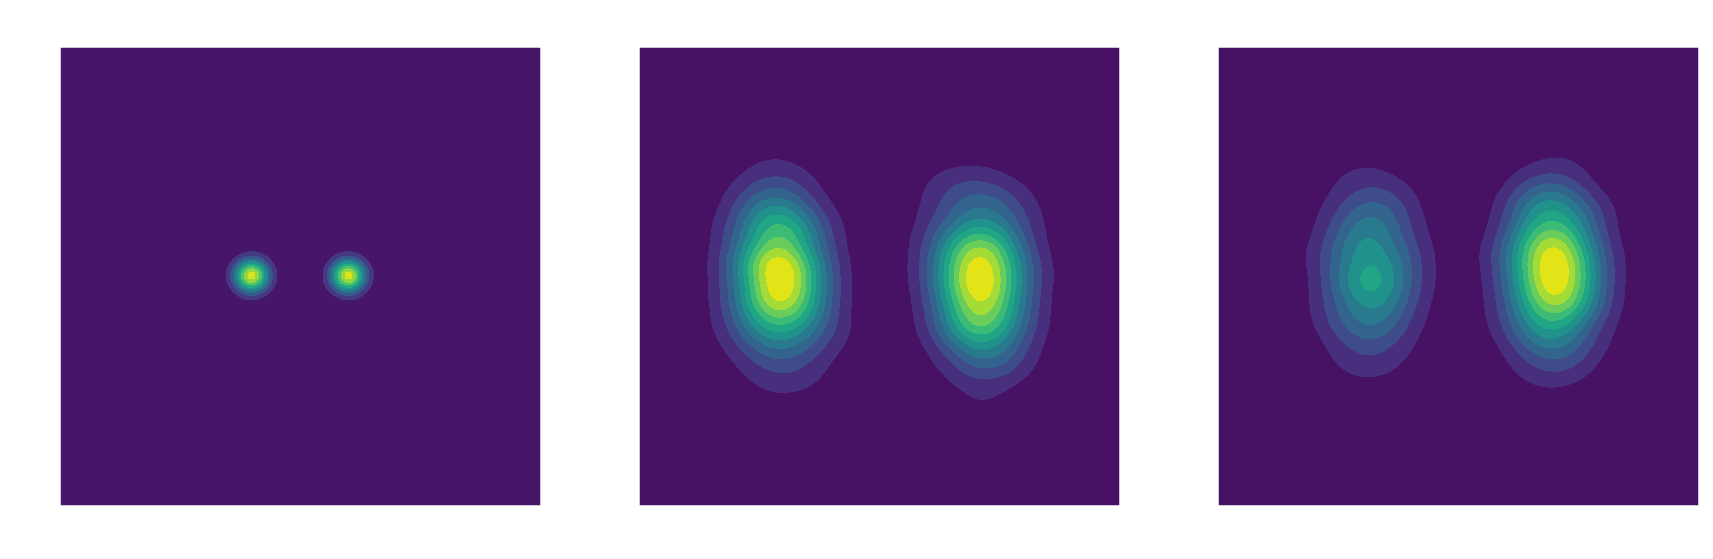

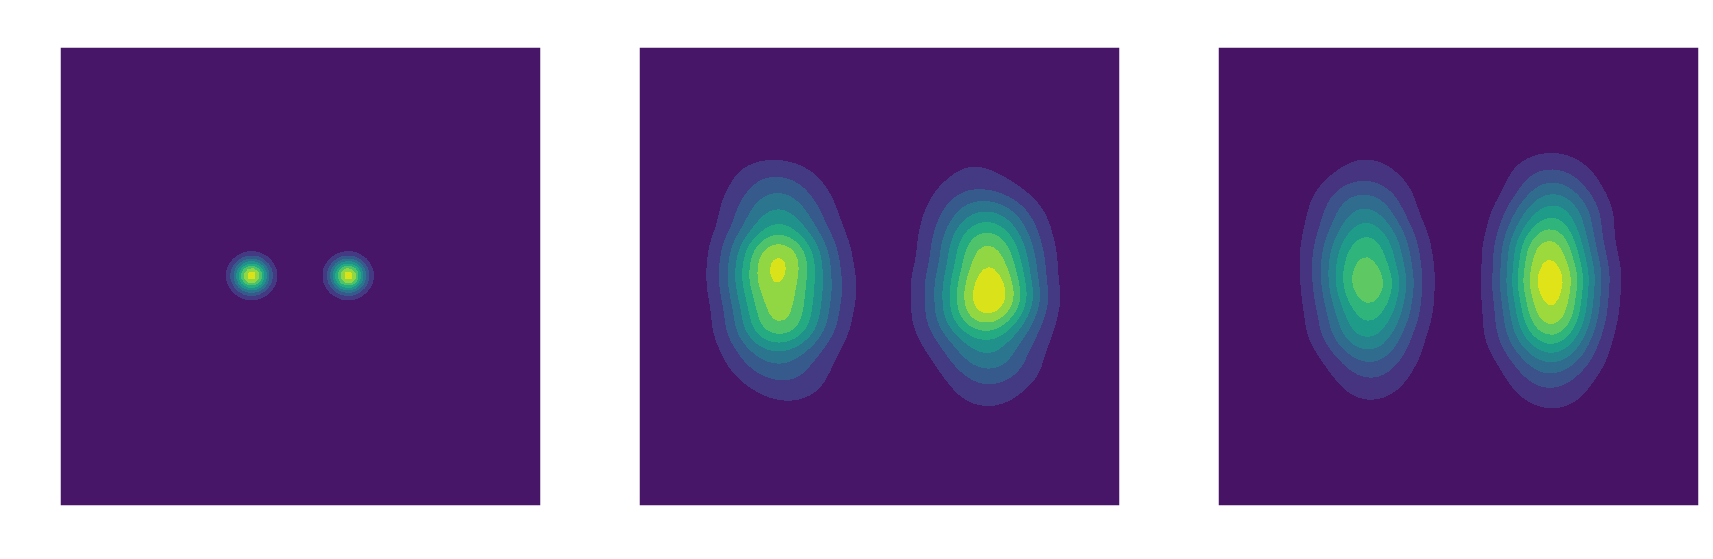

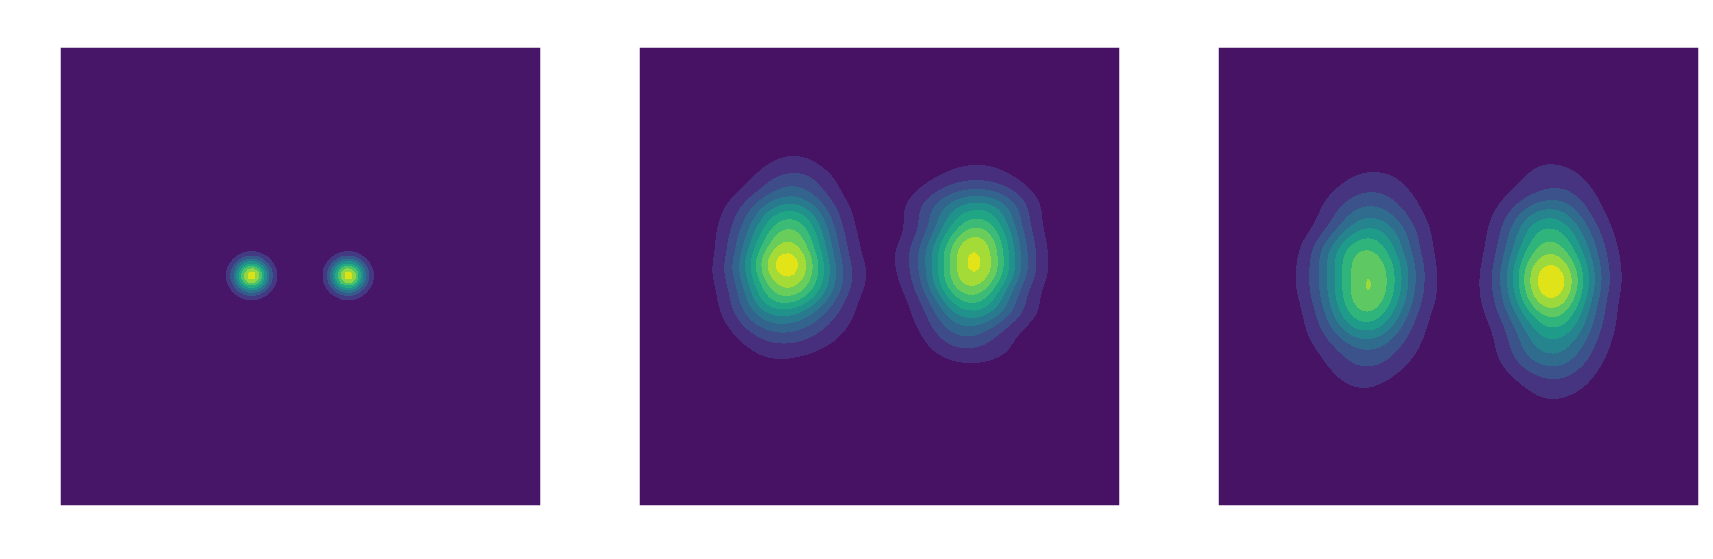

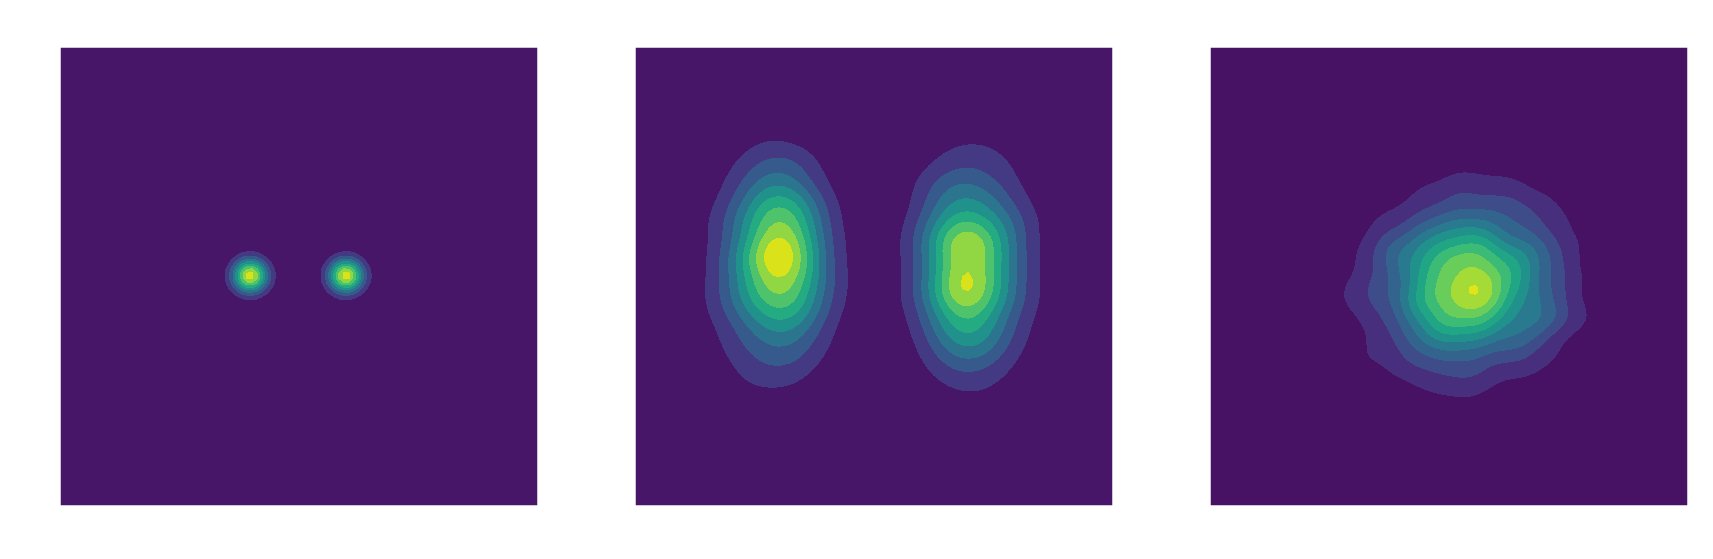

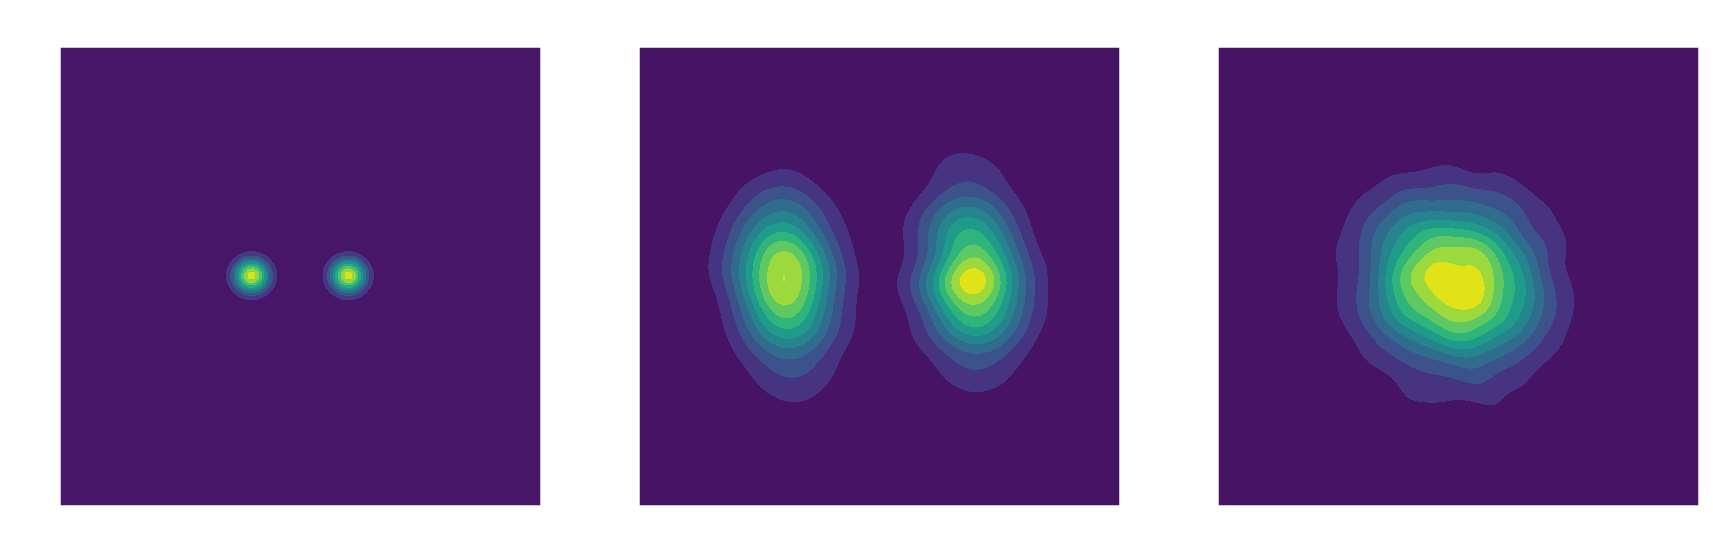

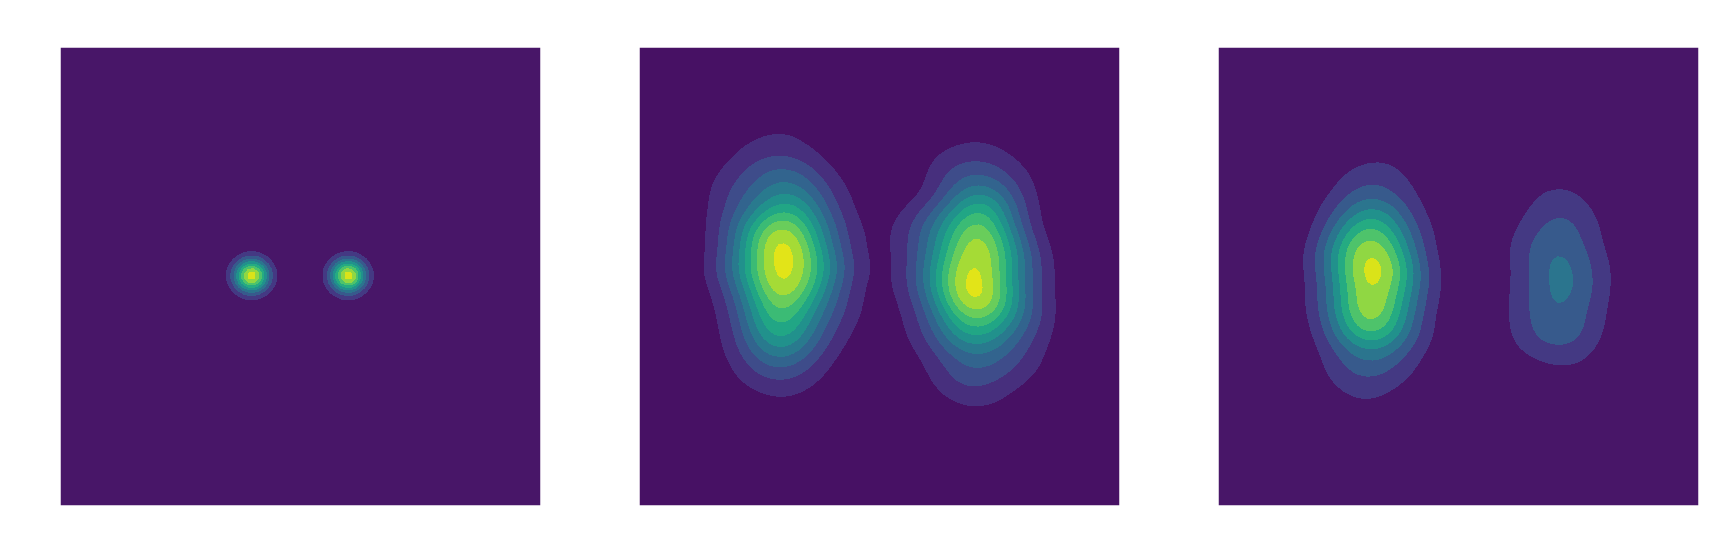

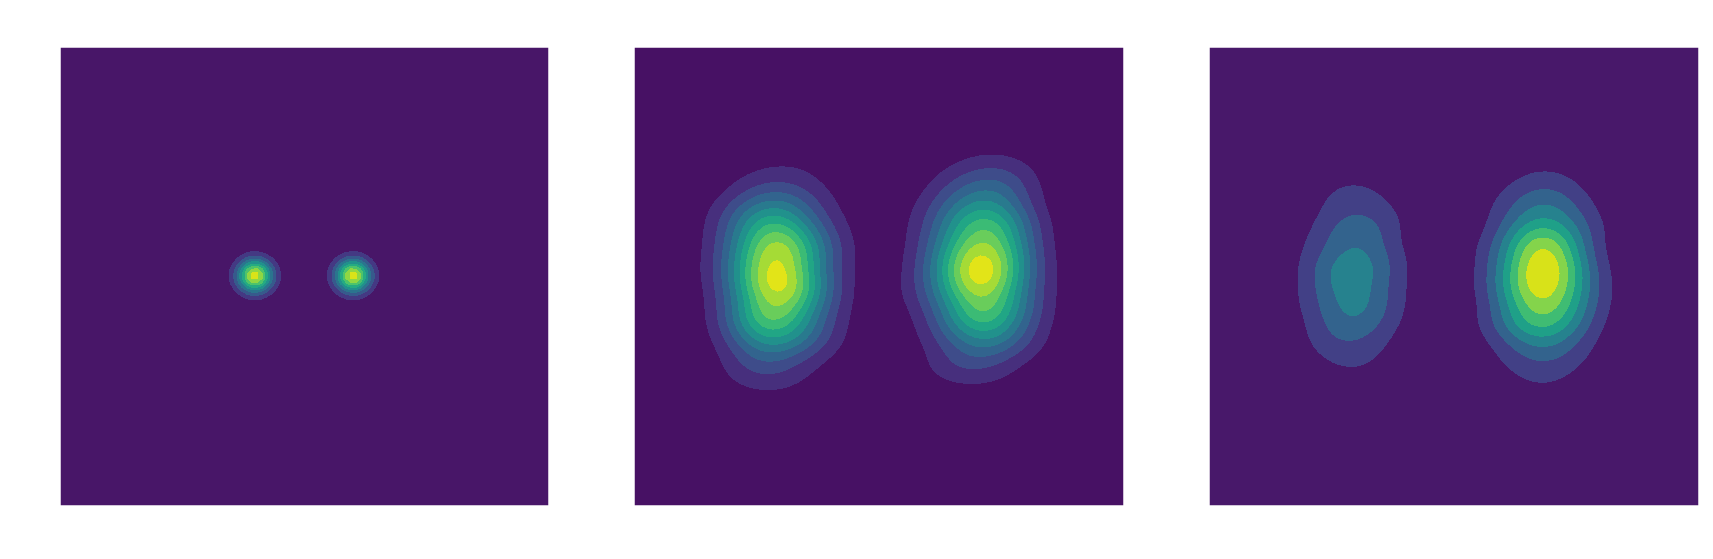

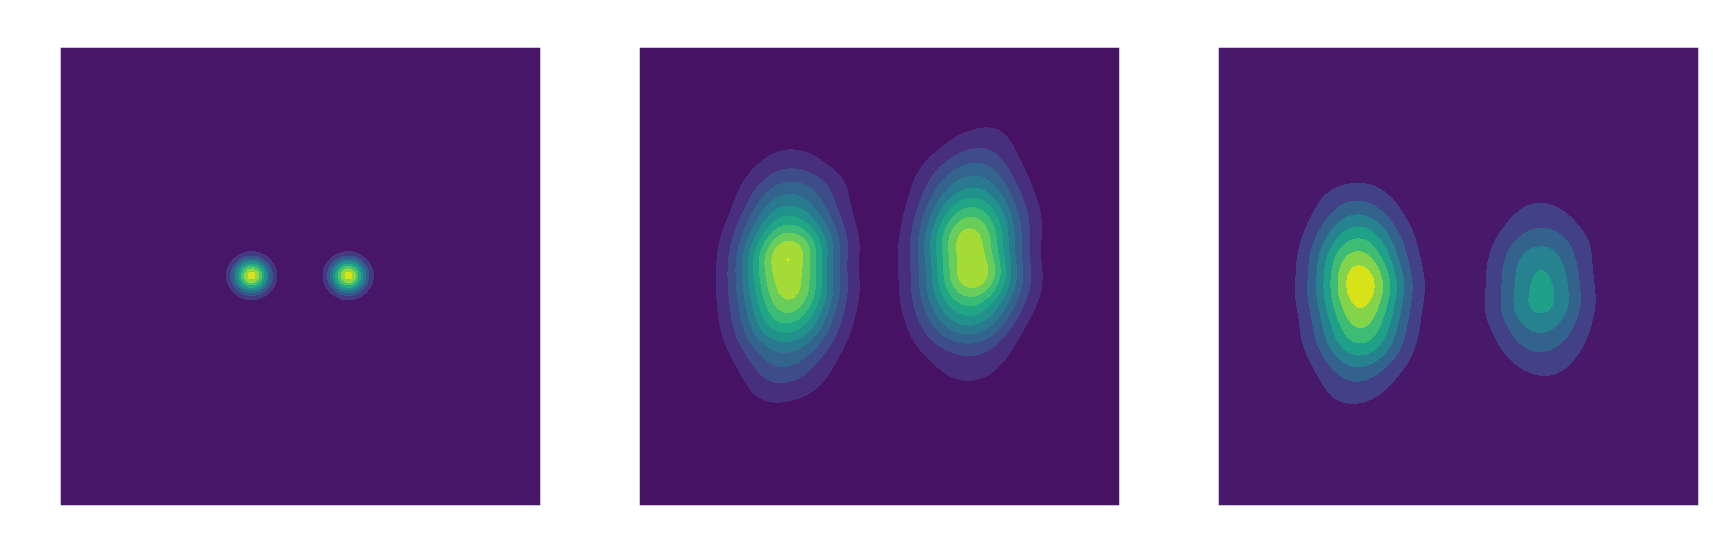

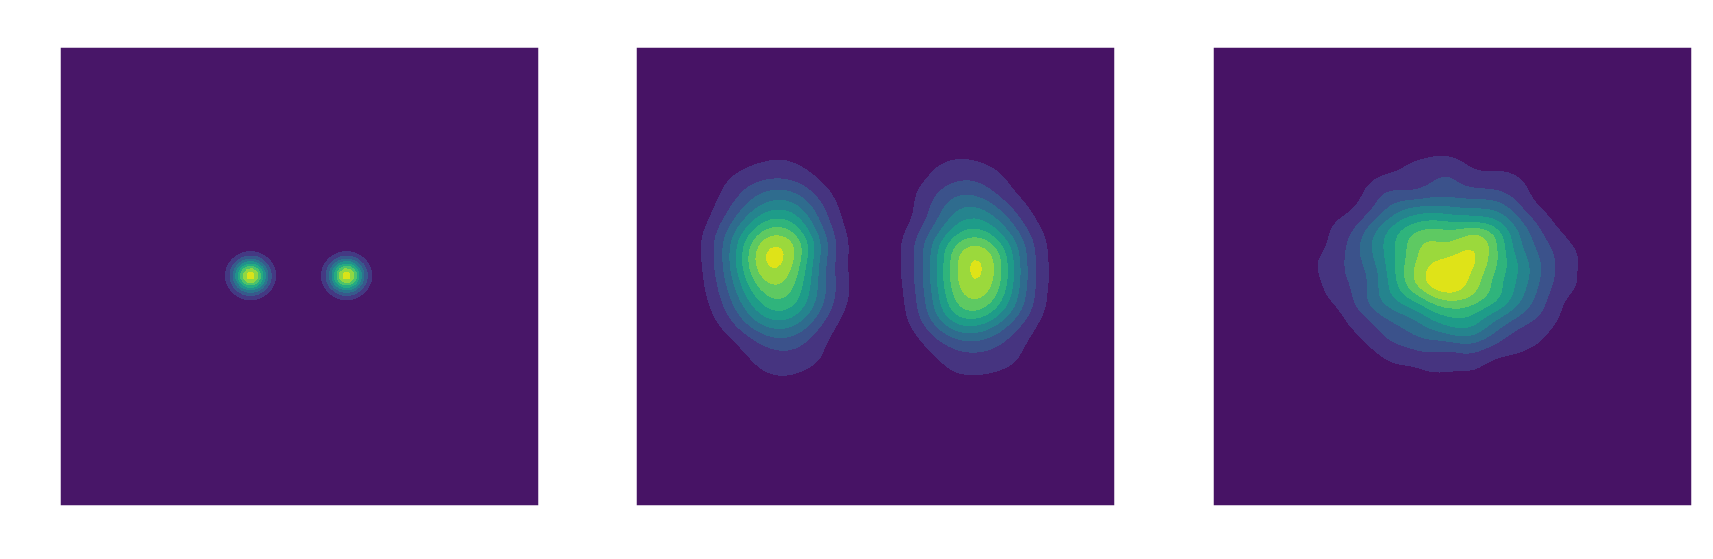

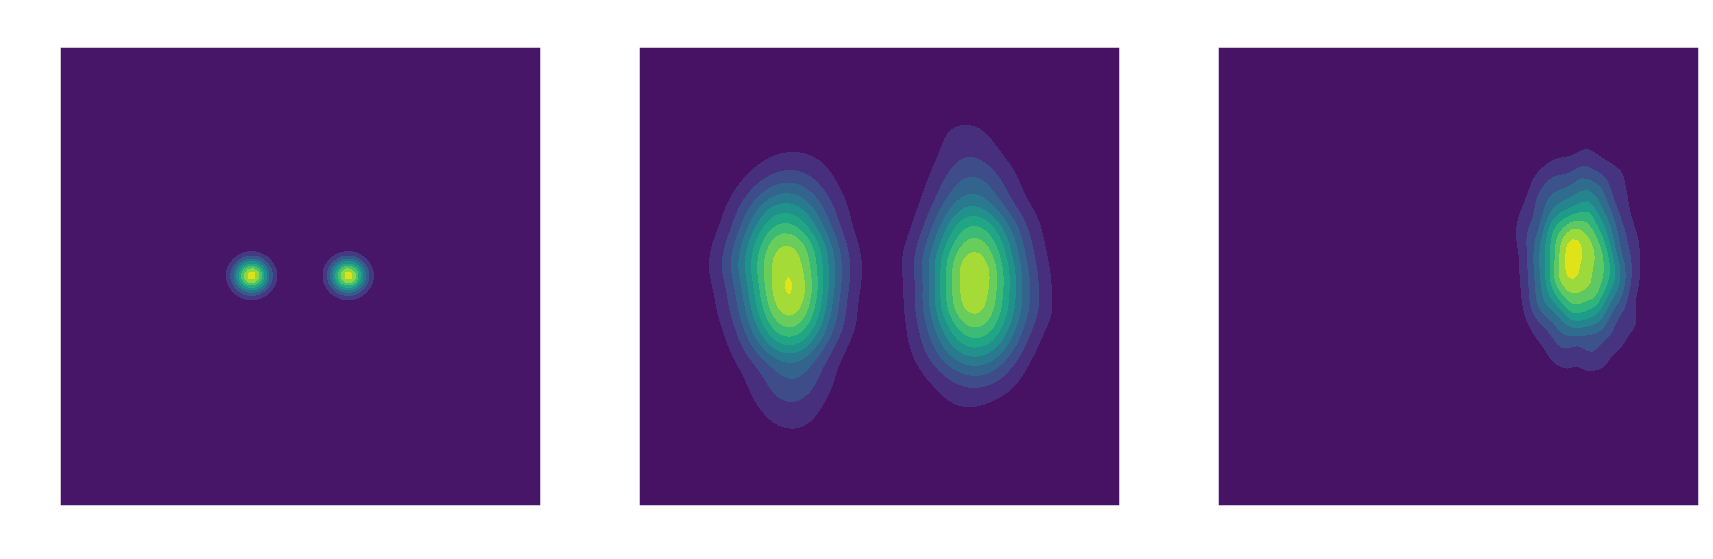

In [45]:
plot_density_estimation(dynamics.potential_fn, x_arr, x_arr_hmc,
                        num_plots=10, title=MODEL_TYPE, cmap='viridis')

Text(0.5, 1.0, 'L2HMC samples')

Text(0.5, 1.0, 'HMC samples')

Text(0.5, 1.0, 'L2HMC samples')

Text(0.5, 1.0, 'HMC samples')

Text(0.5, 1.0, 'L2HMC samples')

Text(0.5, 1.0, 'HMC samples')

Text(0.5, 1.0, 'L2HMC samples')

Text(0.5, 1.0, 'HMC samples')

Text(0.5, 1.0, 'L2HMC samples')

Text(0.5, 1.0, 'HMC samples')

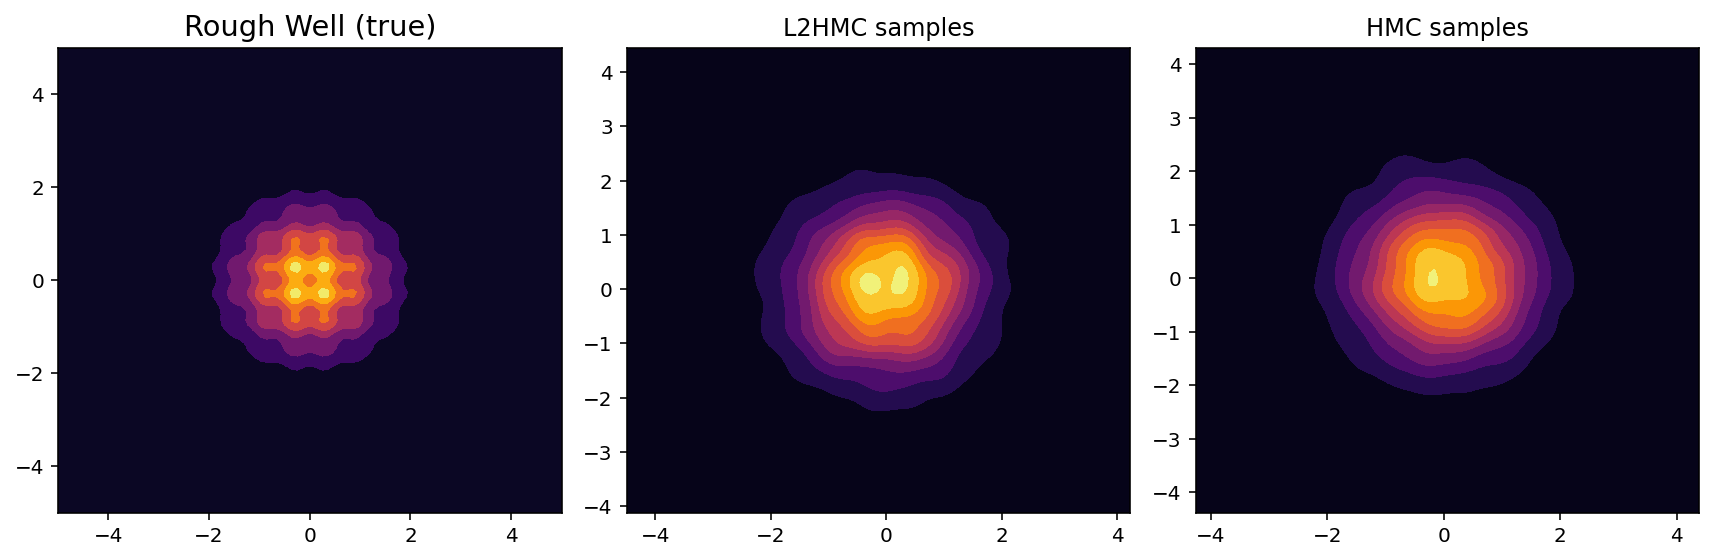

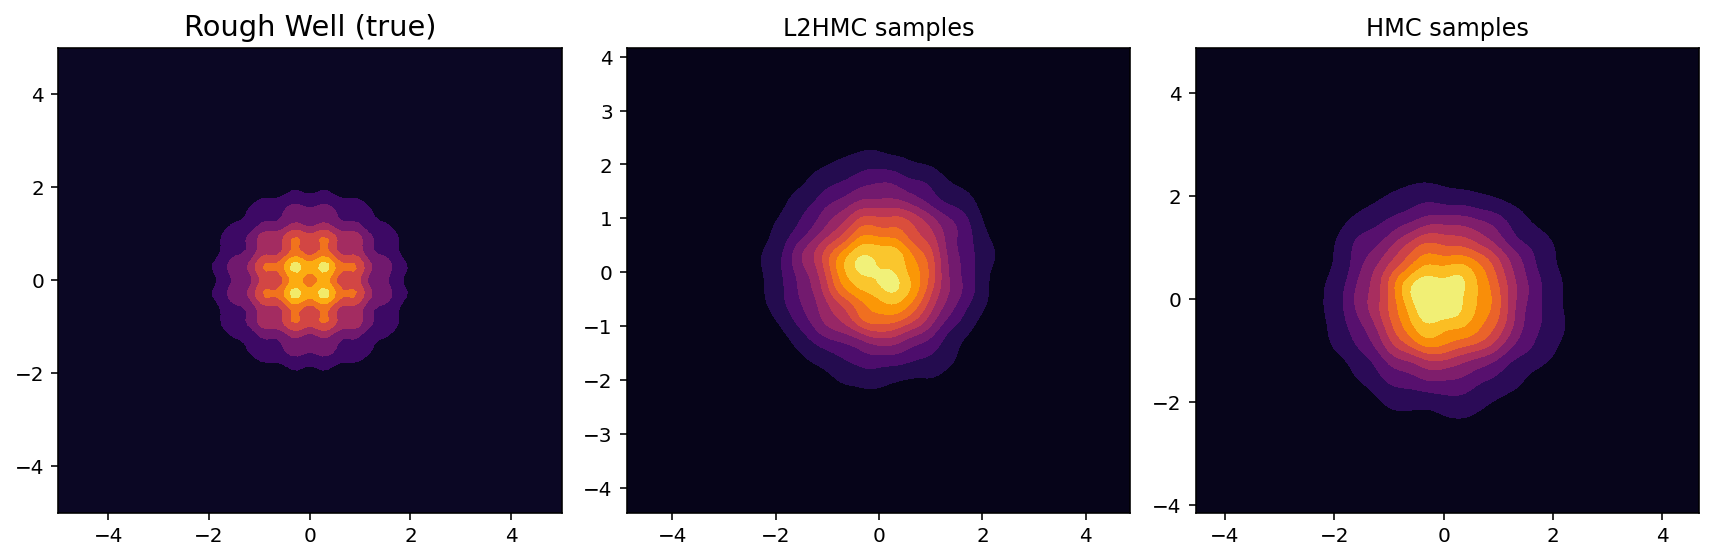

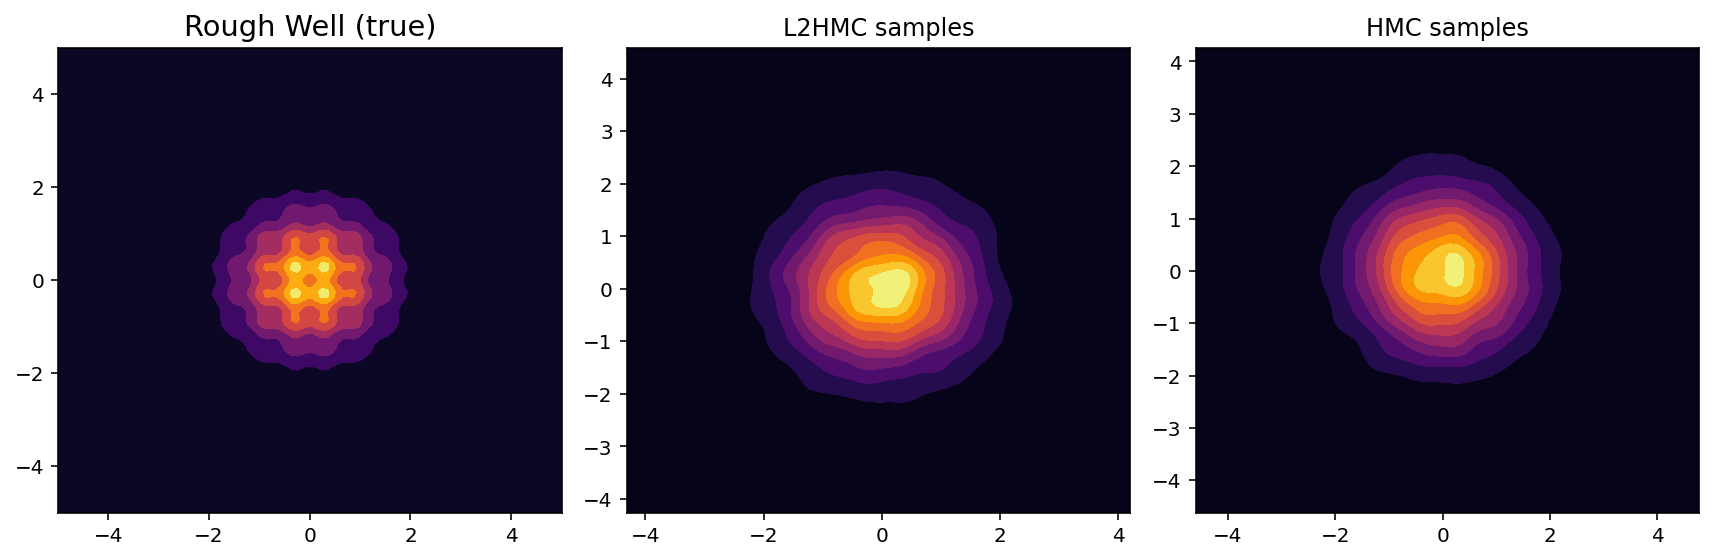

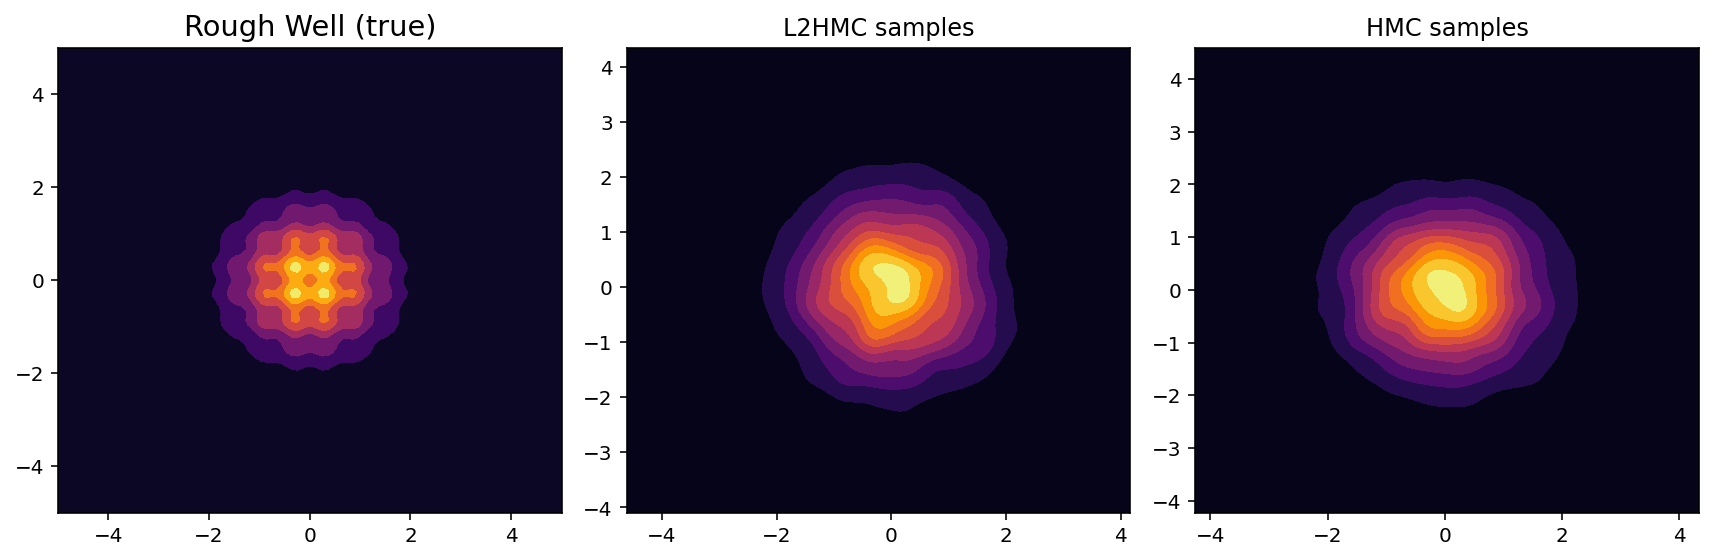

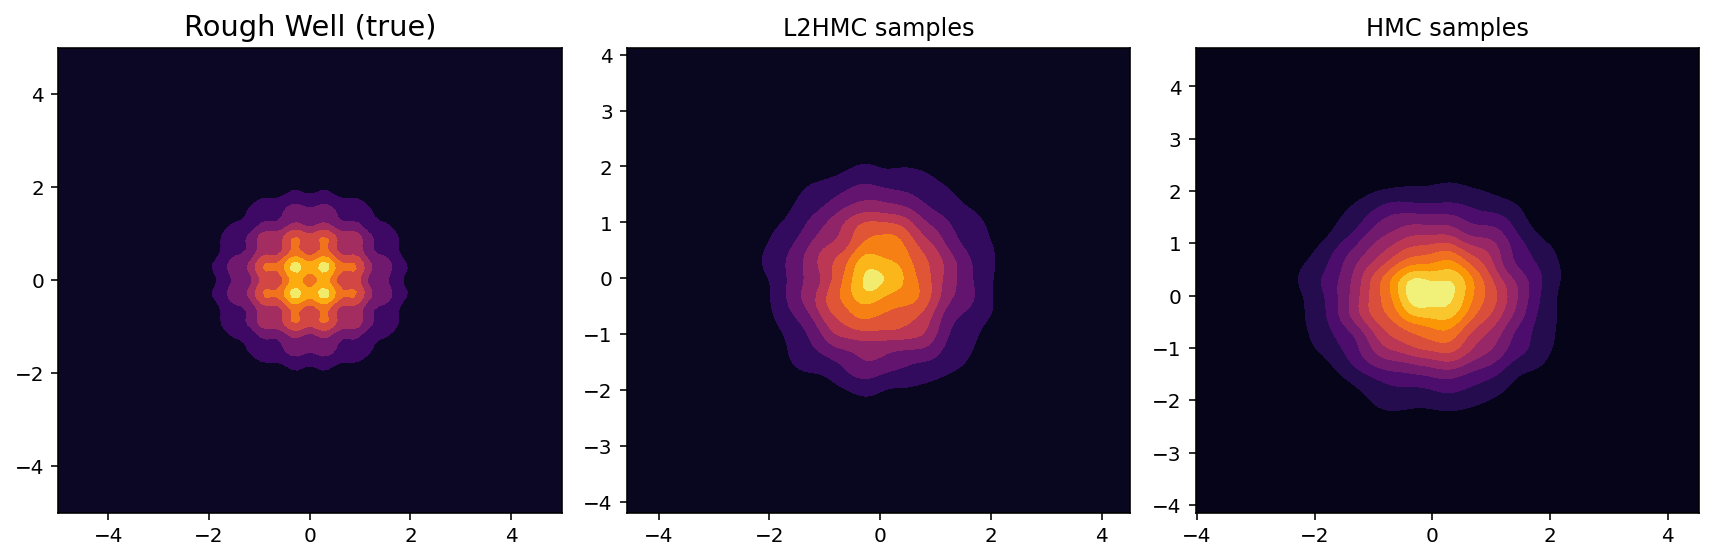

In [77]:
from utils.distributions import contour_potential
xl2hmc = np.array(x_arr)
xhmc = np.array(x_arr_hmc)

for idx in range(5):
    fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
    _ = contour_potential(POTENTIAL_FN, title='Rough Well (true)', ax=axes[0])
    _ = sns.kdeplot(xl2hmc[:, idx, 0], xl2hmc[:, idx, 1],
                    shade=True, cmap='inferno', ax=axes[1])
    _ = sns.kdeplot(xhmc[:, idx, 0], xhmc[:, idx, 1],
                    shade=True, cmap='inferno', ax=axes[2])
    _ = axes[1].set_title('L2HMC samples')
    _ = axes[2].set_title('HMC samples')
    plt.tight_layout()

### L2HMC Samples:

2020-08-31 14:43:10,703:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures
Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain0.png


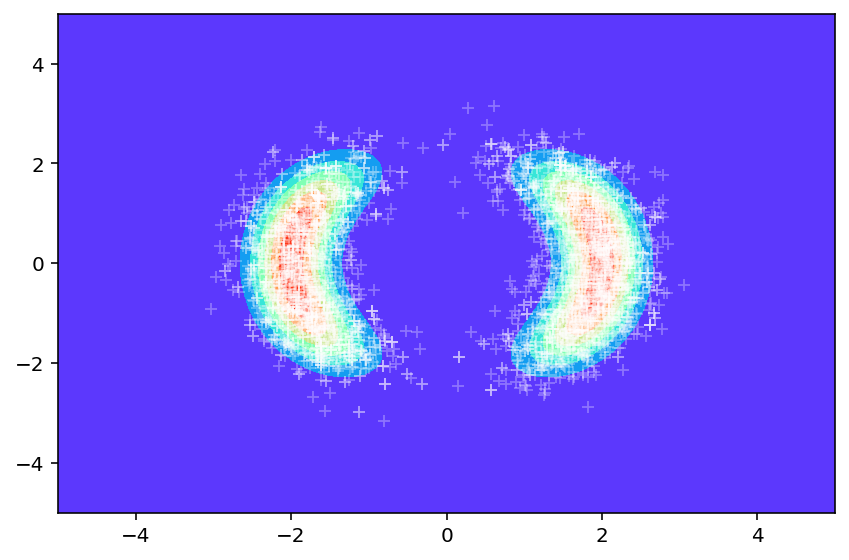

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain1.png


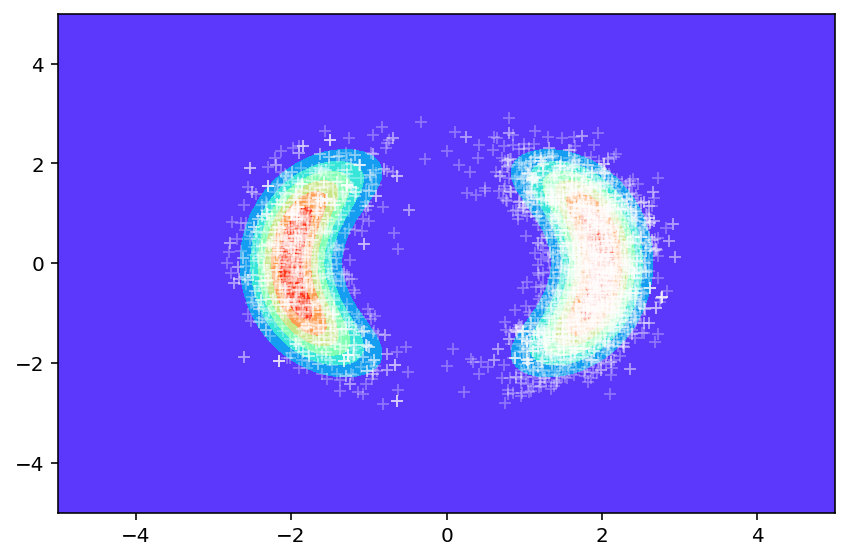

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain2.png


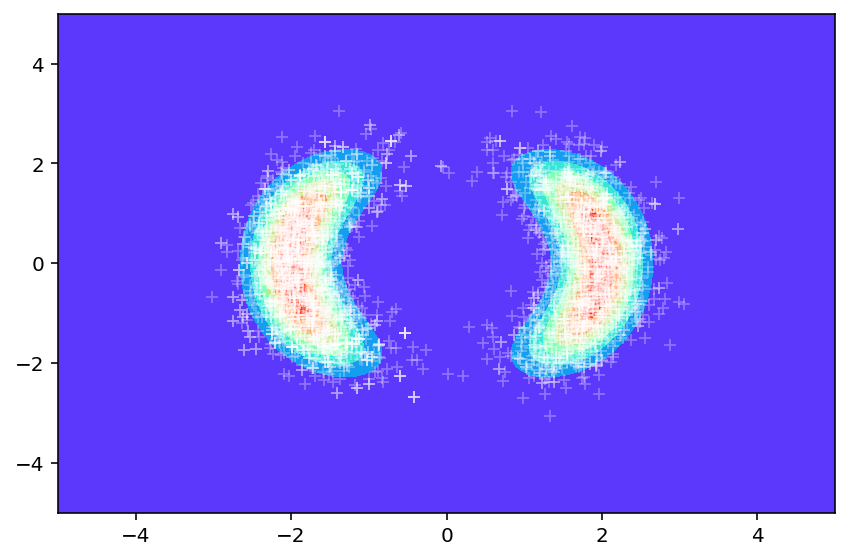

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain3.png


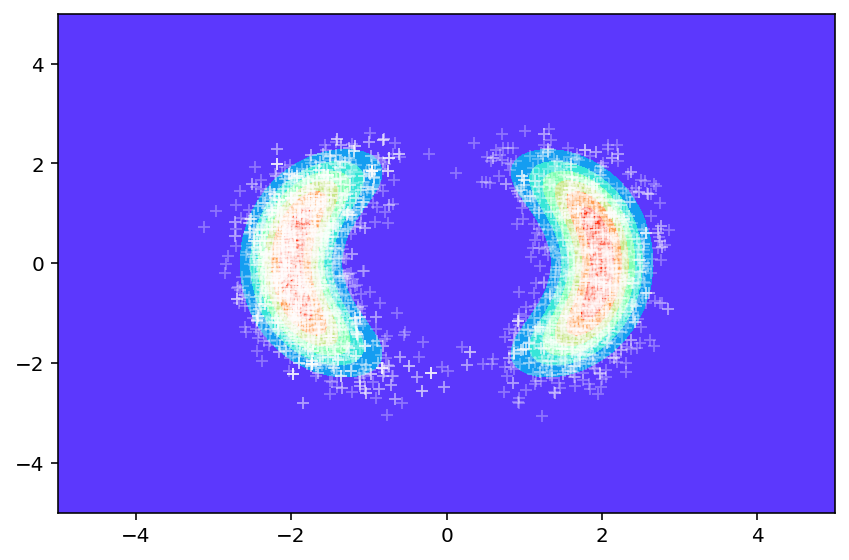

In [19]:
plot_chains(dirs, x_arr, POTENTIAL_FN, label='l2hmc samples', cmap='inferno')

### HMC Samples:

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain0.png


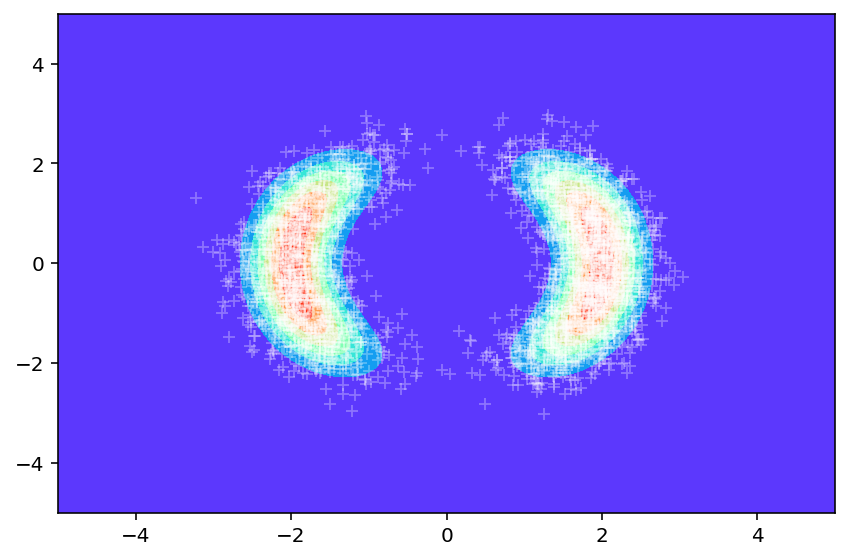

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain1.png


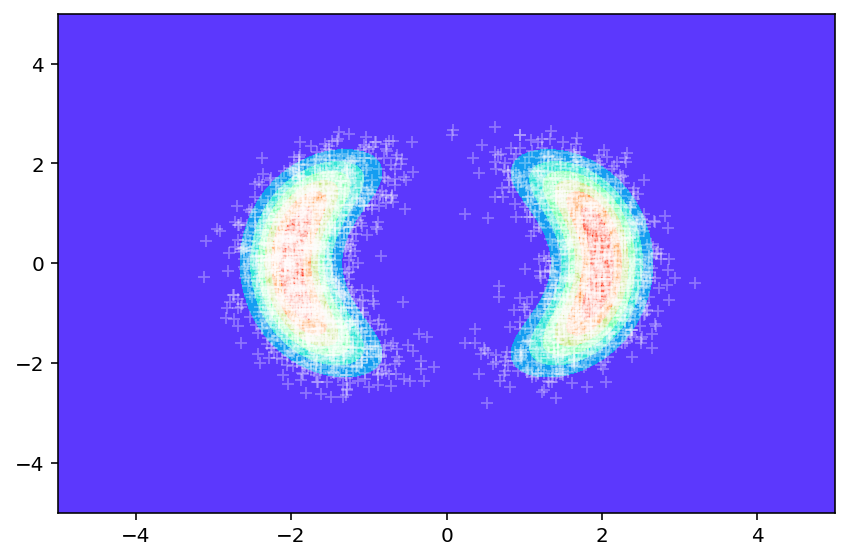

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain2.png


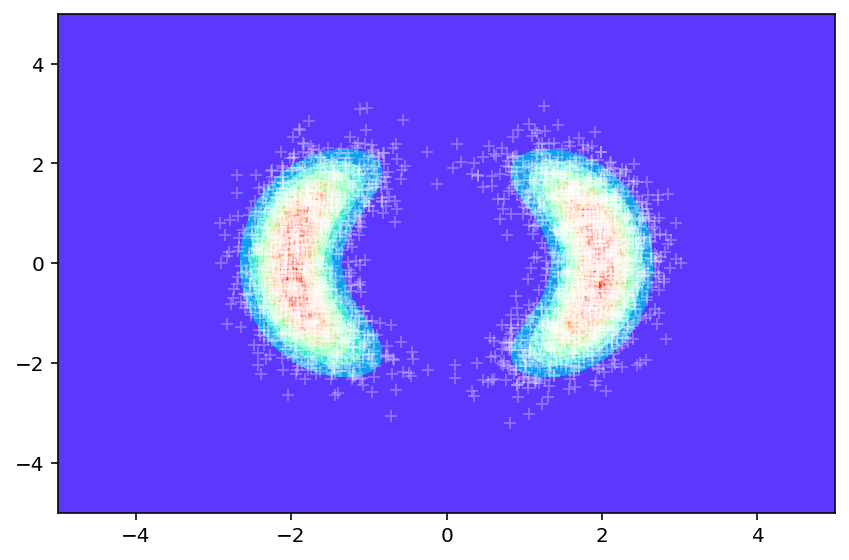

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain3.png


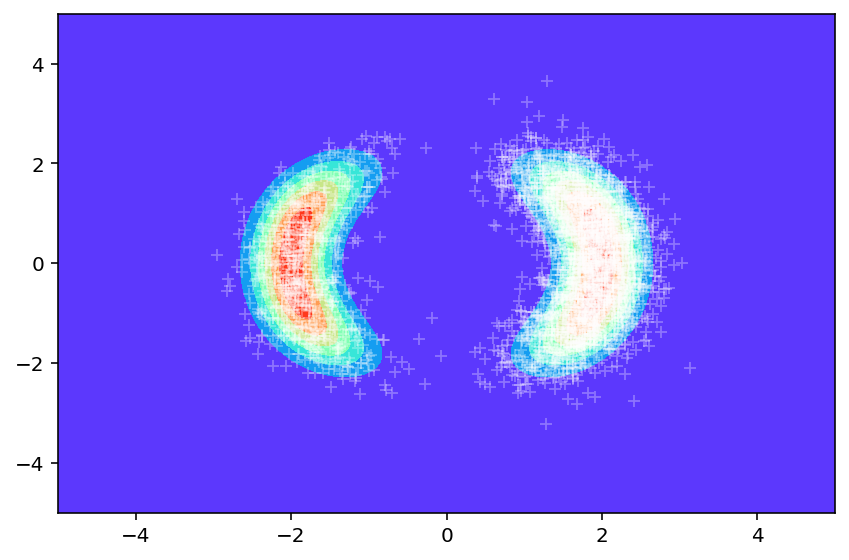

In [20]:
plot_chains(hmc_dirs, x_arr_hmc, POTENTIAL_FN, label='HMC samples', cmap='inferno')